# 0. Prepare Environment 

In [2]:
import dimcli
import numpy as np
import pandas as pd

import country_converter as coco 
import pycountry

import re
import typing
from ast import literal_eval
from typing import Iterable

# import dataframe_image as dfi
import dimcli
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycountry
import seaborn as sns
from scipy.stats import ttest_ind
from sklearn.impute import SimpleImputer

from fuzzywuzzy import fuzz

/Users/chenyuli/anaconda3/envs/py3/lib/python3.11/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [3]:
# dimcli.login(
#     key="", endpoint="https://app.dimensions.ai"
# )
dsl = dimcli.Dsl()

get_new_data = False

# 1. Data Pre-processing 

### Get Data 

In [5]:
def get_split(ser: pd.Series):
    return np.array_split(ser, ser.shape[0] / 400)


def get_data():
    if get_new_data:
        control = pd.read_csv("control-pmid.csv")
        """Query:
        https://pubmed.ncbi.nlm.nih.gov/?term=%28%28%22machine+learning%22%5BMajr%5D+OR+%28%22machine%22%5Bti%5D+AND+%22learning%22%5Bti%5D%29+OR+%22machine+learning%22%5Bti%5D+OR+%22AI%22%5Bti%5D+OR+%22Artificial+Intelligence%22%5Bti%5D+OR+%22artificially+intelligent%22%5Bti%5D+OR+%22Artificial+Intelligence%22%5BMeSH%5D+OR+%22Algorithms%22%5BMeSH%5D+OR+%22algorithm*%22%5Bti%5D+OR+%22deep+learning%22%5Bti%5D+OR+%22computer+vision%22%5Bti%5D+OR+%22natural+language+processing%22%5Bti%5D+OR+%22neural+network*%22%5Bti%5D+OR+%22neural+networks%2C+computer%22%5BMeSH%5D+OR+%22intelligent+machine*%22%5Bti%5D%29+AND+%28exp+%22Intensive+Care+Units%22%2F+OR+exp+%22Critical+Care%22%2F+OR+%28ICU+OR+IC+OR+%28%28intensive+OR+critical%29+ADJ3+%28care+OR+therapy+OR+unit*+OR+patient*+OR+department%5C*%29%29%29%29%29&filter=years.2010-2023
        """
        df_pubs_control = pd.DataFrame()
        df_auths_control = pd.DataFrame()
        df_affils_control = pd.DataFrame()

        for pmid_list in get_split(control.PMID):
            query = fr"""search publications where pmid in {list(pmid_list)} and year in [2010:2022]
            return publications[basics+abstract+authors_count+doi+concepts_scores+times_cited+mesh_terms
            +journal+editors+field_citation_ratio+funder_countries+funders+open_access
            +relative_citation_ratio+publisher+pmid+supporting_grant_ids+research_org_cities+pmid
            +research_org_countries+research_org_country_names+research_org_names+research_org_state_codes
            +research_org_state_names+research_orgs+researchers+category_bra+category_for+category_hra+category_hrcs_hc+
            category_hrcs_rac+category_icrp_cso+category_icrp_ct+category_rcdc+category_sdg+category_uoa]"""
            data = dsl.query_iterative(query)
            df_pubs_control = pd.concat([df_pubs_control, data.as_dataframe()])
            df_auths_control = pd.concat(
                [df_auths_control, data.as_dataframe_authors()]
            )
            df_affils_control = pd.concat(
                [df_affils_control, data.as_dataframe_authors_affiliations()]
            )

        df_pubs_control.to_csv("control_group_pubs.csv")
        df_auths_control.to_csv("control_group_auths.csv")
        df_affils_control.to_csv("control_group_affils.csv")

        compare_query = fr"""search publications where year in [2010:2022] for "\"datamed org display item php\" OR \"physionet mimic ii database\" 
        OR \"mimic iii medical information mart for intensive care\" OR
        \"10.13026 s6n6 xd98\" OR \"mimic iv\" OR \"physionet org content mimiciv\" OR
        \"eicu crd\" OR \"mimic cxr\"" return publications[basics+abstract+authors_count+doi+concepts_scores+times_cited
            +mesh_terms+journal+editors+field_citation_ratio+funder_countries+funders+open_access
            +relative_citation_ratio+publisher+pmid+supporting_grant_ids+research_org_cities+pmid
            +research_org_countries+research_org_country_names+research_org_names+research_org_state_codes
            +research_org_state_names+research_orgs+researchers+category_bra+category_for+category_hra+category_hrcs_hc+
            category_hrcs_rac+category_icrp_cso+category_icrp_ct+category_rcdc+category_sdg+category_uoa]"""
        compare = dsl.query_iterative(compare_query)

        df_pubs_compare = compare.as_dataframe()
        df_auths_compare = compare.as_dataframe_authors()
        df_affils_compare = compare.as_dataframe_authors_affiliations()

        df_pubs_compare.to_csv("mimic_pubs.csv")
        df_auths_compare.to_csv("mimic_auths.csv")
        df_affils_compare.to_csv("mimic_affils.csv")

    else:
        df_pubs_compare = pd.read_csv("./MIMIC_Files/mimic_pubs.csv")
        df_auths_compare = pd.read_csv("./MIMIC_Files/mimic_auths.csv")
        df_affils_compare = pd.read_csv("./MIMIC_Files/mimic_affils.csv")

        df_pubs_control = pd.read_csv("./MIMIC_Files/control_group_pubs.csv")
        df_auths_control = pd.read_csv("./MIMIC_Files/control_group_auths.csv")
        df_affils_control = pd.read_csv("./MIMIC_Files/control_group_affils.csv")

    return (
        df_pubs_compare,
        df_auths_compare,
        df_affils_compare,
        df_pubs_control,
        df_auths_control,
        df_affils_control,
    )

In [6]:
(
    df_pubs_compare,
    df_auths_compare,
    df_affils_compare,
    df_pubs_control,
    df_auths_control,
    df_affils_control,
) = get_data()

In [7]:
print(len(df_pubs_compare))
print(len(df_pubs_control))
print(len(df_auths_compare))
print(len(df_auths_control))
print(len(df_affils_compare))
print(len(df_affils_control))

2307
2912
13879
20539
13967
25676


#### preprocessing pipeline
need data _name_genderize_output (1).csv 

In [6]:
df_gender_dictionary = pd.read_csv("_name_genderize_output (1).csv") ### check dataset 
df_gender_dictionary.drop_duplicates("ga_first_name", inplace=True)
df_gender_dictionary.set_index("ga_first_name", inplace=True)


CountryClass = pd.read_excel("CountryClassWordBank (1).xlsx")
CountryClass_2 = CountryClass.copy()
CountryClass_2.set_index("Code", inplace=True)
missing_codes = []


gender_dict = dict(zip(df_gender_dictionary.index, df_gender_dictionary.ga_gender))
country_dict = dict(zip(CountryClass_2.index, CountryClass_2["Income group"]))
gender_map = {"male": 0, "female": 1, "unknown": np.nan}
income_map = {
    "High income": 4,
    "Upper middle income": 3,
    "Lower middle income": 2,
    "Low income": 1,
}


def get_gender(name):
    if pd.isna(name):
        return np.nan
    name = name.strip()
    name = name.split(sep=" ")[0]
    if name in gender_dict:
        return gender_dict[name]
    else:
        return np.nan


def get_gender_ints(gender):
    if gender in gender_map:
        return gender_map[gender]
    else:
        return np.nan


def get_country_income(country_code):
    if pd.isna(country_code):
        return np.nan
    country_ISO3 = pycountry.countries.get(alpha_2=country_code)
    if country_ISO3 is None:
        missing_codes.append(country_code)
        return np.nan
    elif country_ISO3.alpha_3 in country_dict:
        return country_dict[country_ISO3.alpha_3]
    else:
        missing_codes.append(country_code)
        return np.nan


def map_country_income(income_group):
    if income_group in income_map:
        return income_map[income_group]
    else:
        return np.nan


def get_pub_year(pub_id, df_pubs):
    return df_pubs.at[pub_id, "year"]


def categorize_author_counts(num_authors):
    if pd.isna(num_authors) or num_authors == 0:
        return np.nan
    if num_authors == 1:
        return "1"
    if num_authors == 2:
        return "2"
    if num_authors >= 3 and num_authors <= 5:
        return "3-5"
    if num_authors >= 6:
        return "6+"
    return np.nan


def pipeline(list_of_dataframes: list):
    df_pubs, df_auths, df_affils = list_of_dataframes
    df_pubs_copy = df_pubs.copy()
    df_pubs_copy.set_index("id", inplace=True)

    df_auths["year"] = df_auths["pub_id"].apply(
        lambda pid: get_pub_year(pid, df_pubs_copy)
    )
    df_affils["year"] = df_affils["pub_id"].apply(
        lambda pid: get_pub_year(pid, df_pubs_copy)
    )

    df_auths["first_name"] = df_auths["first_name"].str.title()
    df_affils["first_name"] = df_affils["first_name"].str.title()

    df_auths["gender"] = df_auths["first_name"].map(get_gender)
    df_affils["gender"] = df_affils["first_name"].map(get_gender)

    df_auths["gender_ints"] = df_auths["gender"].map(get_gender_ints)
    df_affils["gender_ints"] = df_affils["gender"].map(get_gender_ints)

    df_pubs["author_count_categories"] = df_pubs["authors_count"].apply(
        categorize_author_counts
    )

    lfirstnames = dict.fromkeys(df_pubs.id, np.nan)
    lgenders = dict.fromkeys(df_pubs.id, np.nan)
    lpctfemale = dict.fromkeys(df_pubs.id, np.nan)
    lffirst = dict.fromkeys(df_pubs.id, np.nan)
    lflast = dict.fromkeys(df_pubs.id, np.nan)
    lnfemale = dict.fromkeys(df_pubs.id, np.nan)
    lnmale = dict.fromkeys(df_pubs.id, np.nan)
    lnnan = dict.fromkeys(df_pubs.id, np.nan)

    for pub_id, df_info in df_auths.groupby("pub_id"):
        lfirstnames[pub_id] = df_info["first_name"]
        lgenders[pub_id] = df_info["gender_ints"]

        genders = df_info["gender_ints"]

        lffirst[pub_id] = genders.iloc[0]
        lflast[pub_id] = genders.iloc[-1]

        num_female = (genders == 1).sum()
        num_male = (genders == 0).sum()
        num_missing = genders.isna().sum()
        lnfemale[pub_id] = num_female  
        lnmale[pub_id] = num_male 
        lnnan[pub_id] = num_missing  
        total = num_male + num_female
        if total == 0:
            lpctfemale[pub_id] = np.nan
        else:
            lpctfemale[pub_id] = num_female / total

    df_pubs["first_names"] = lfirstnames.values()
    df_pubs["genders"] = lgenders.values()
    df_pubs["num_female"] = lnfemale.values()
    df_pubs["num_male"] = lnmale.values()
    df_pubs["num_na"] = lnnan.values()
    df_pubs["pct_female_real"] = lpctfemale.values()
    df_pubs["female_first"] = lffirst.values()
    df_pubs["female_last"] = lflast.values()

    cols = ["num_female", "num_male", "num_na"]
    total = df_pubs[cols[0]] + df_pubs[cols[1]] + df_pubs[cols[2]]
    df_pubs["pct_female_pessimistic"] = df_pubs[cols[0]] / total
    df_pubs["pct_female_optimistic"] = (df_pubs[cols[0]] + df_pubs[cols[2]]) / total
    df_pubs["female_first_pessimistic"] = df_pubs["female_first"].apply(
        lambda x: 0 if pd.isna(x) else x
    )
    df_pubs["female_first_optimistic"] = df_pubs["female_first"].apply(
        lambda x: 1 if pd.isna(x) else x
    )
    df_pubs["female_last_pessimistic"] = df_pubs["female_last"].apply(
        lambda x: 0 if pd.isna(x) else x
    )
    df_pubs["female_last_optimistic"] = df_pubs["female_last"].apply(
        lambda x: 1 if pd.isna(x) else x
    )

    df_affils["income_class"] = df_affils["aff_country_code"].apply(get_country_income)
    df_affils["income_class_num"] = df_affils["income_class"].map(map_country_income)

    return [df_pubs, df_auths, df_affils]

FileNotFoundError: [Errno 2] No such file or directory: '_name_genderize_output (1).csv'

# 1. Gender Analysis

In [8]:
df_auths_compare.head()

,Unnamed: 0,affiliations,corresponding,current_organization_id,first_name,last_name,orcid,raw_affiliation,researcher_id,pub_id,year,gender,gender_ints
0,0,[],NaN,NaN,Feng,Shen,[],[],NaN,pub.1154752616,2022,male,0.0
1,1,[],NaN,NaN,Qimin,CHEN,[],[],NaN,pub.1154752616,2022,female,1.0
2,2,[],NaN,NaN,Wei,Li,[],[],NaN,pub.1154752616,2022,male,0.0
3,3,[],NaN,NaN,Ying,Wang,[],[],NaN,pub.1154752616,2022,female,1.0
4,4,[],NaN,NaN,Xianjun,CHEN,[],[],NaN,pub.1154752616,2022,male,0.0


In [9]:
# Filter the DataFrame to show only non-duplicated records based on 'first_name' and 'last_name'.
non_duplicated_authors_compare = df_auths_compare[~df_auths_compare[['first_name', 'last_name','researcher_id']].duplicated()]
non_duplicated_authors_control = df_auths_control[~df_auths_control[['first_name', 'last_name','researcher_id']].duplicated()]


In [10]:
print("Compare distinct author names ",len(non_duplicated_authors_compare))
print("Control distinct author names ",len(non_duplicated_authors_control))
print("Compare distinct author names with gender not none ",len(non_duplicated_authors_compare[non_duplicated_authors_compare.gender.notna()]))
print("Control distinct author names with gender not none",len(non_duplicated_authors_control[non_duplicated_authors_control.gender.notna()]))
print("Compare distinct author names -female",len(non_duplicated_authors_compare[non_duplicated_authors_compare.gender=='female']))
print("Control distinct author names -female",len(non_duplicated_authors_control[(non_duplicated_authors_control.gender=='female')]))
print(2438/8758)
print(4710/15285)



Compare distinct author names  9959
Control distinct author names  17999
Compare distinct author names with gender not none  8758
Control distinct author names with gender not none 15285
Compare distinct author names -female 2438
Control distinct author names -female 4710
0.2783740580041105
0.30814524043179586


In [11]:
def get_missingness(df_pubs, df_auths, df_affils):
    df_completeness = pd.DataFrame()
    df_completeness["id"] = df_pubs["id"]

    df_completeness["Publications"] = True
    df_completeness["Authors"] = df_pubs.id.isin(df_auths.pub_id)
    df_completeness["Affiliations"] = df_pubs.id.isin(df_affils.pub_id)

    df_completeness.head()
    print(f"Total numbers of publications:   {len(df_completeness)}")
    print(f"Papers w/ Missing Publications:   0")
    print(
        f"Papers w/ Missing Authors:        {df_completeness.Authors.value_counts()[False]}"
    )
    print(
        f"Papers w/ Missing Affiliations:   {df_completeness.Affiliations.value_counts()[False]}"
    )

    return None  # df_completeness


print("Compare")
get_missingness(df_pubs_compare, df_auths_compare, df_affils_compare)
print()
print("Control")
get_missingness(df_pubs_control, df_auths_control, df_affils_control)

Compare
Total numbers of publications:   2307
Papers w/ Missing Publications:   0
Papers w/ Missing Authors:        110
Papers w/ Missing Affiliations:   635

Control
Total numbers of publications:   2912
Papers w/ Missing Publications:   0
Papers w/ Missing Authors:        2
Papers w/ Missing Affiliations:   35


In [12]:
print("Compare missing Affiliation percentage",635/2307)
print("Control missing Affiliation percentage",35/2912)



Compare missing Affiliation percentage 0.2752492414390984
Control missing Affiliation percentage 0.01201923076923077


In [13]:
num_compare_auths = df_auths_compare.shape[0]
num_control_auths = df_auths_control.shape[0]
num_total_auths = num_compare_auths + num_control_auths

print(
    f"Compare group authors: {num_compare_auths}. Pct: {num_compare_auths / num_total_auths}"
)
print(
    f"Control group authors: {num_control_auths}. Pct: {num_control_auths / num_total_auths}"
)
print(f"Total:                 {num_total_auths}")

Compare group authors: 13879. Pct: 0.40324830030797837
Control group authors: 20539. Pct: 0.5967516996920216
Total:                 34418


In [14]:
num_compare = df_pubs_compare.shape[0]
num_control = df_pubs_control.shape[0]
num_total = num_compare + num_control

print(f"Compare group papers: {num_compare}. Pct: {num_compare / num_total}")
print(f"Control group papers: {num_control}. Pct: {num_control / num_total}")
print(f"Total:                {num_total}")

Compare group papers: 2307. Pct: 0.4420387047327074
Control group papers: 2912. Pct: 0.5579612952672925
Total:                5219


In [15]:
num_compare_auths = df_auths_compare.shape[0]
num_control_auths = df_auths_control.shape[0]
num_total_auths = num_compare_auths + num_control_auths

print(
    f"Compare group authors: {num_compare_auths}. Pct: {num_compare_auths / num_total_auths}"
)
print(
    f"Control group authors: {num_control_auths}. Pct: {num_control_auths / num_total_auths}"
)
print(f"Total:                 {num_total_auths}")

Compare group authors: 13879. Pct: 0.40324830030797837
Control group authors: 20539. Pct: 0.5967516996920216
Total:                 34418


In [16]:
def process(df_pubs, df_auths, df_affils):
    # Get rid of papers with missing genders
    pubs = df_pubs[df_pubs.num_na == 0]
    auths = df_auths[df_auths.pub_id.isin(pubs.id)]
    affils = df_affils[df_affils.pub_id.isin(pubs.id)]
    return pubs, auths, affils


def print_col(col):
    print(col)
    print()
    print("Compare:")
    print(df_pubs_compare[col].describe())
    print()
    print("Control:")
    print(df_pubs_control[col].describe())
    print()


df_pubs_compare, df_auths_compare, df_affils_compare = process(
    df_pubs_compare, df_auths_compare, df_affils_compare
)

df_pubs_control, df_auths_control, df_affils_control = process(
    df_pubs_control, df_auths_control, df_affils_control
)

print_col("pct_female_real")
print_col("female_first")
print_col("female_last")

pct_female_real

Compare:
count    1426.000000
mean        0.261378
std         0.230498
min         0.000000
25%         0.000000
50%         0.250000
75%         0.400000
max         1.000000
Name: pct_female_real, dtype: float64

Control:
count    1823.000000
mean        0.290255
std         0.252795
min         0.000000
25%         0.000000
50%         0.250000
75%         0.500000
max         1.000000
Name: pct_female_real, dtype: float64

female_first

Compare:
count    1426.000000
mean        0.281206
std         0.449746
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: female_first, dtype: float64

Control:
count    1823.000000
mean        0.309380
std         0.462365
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: female_first, dtype: float64

female_last

Compare:
count    1426.000000
mean        0.235624
std         0.424537
min         0.000000
25%  

In [17]:
def get_female_any(df_auths):
    atleast_one = (
        df_auths.groupby("pub_id")["gender_ints"].any().value_counts()[True]
    )
    none = df_auths.groupby("pub_id")["gender_ints"].any().value_counts()[False]
    total = df_auths["pub_id"].nunique()

    print(f"Any female author: {atleast_one}  /  {atleast_one / total}")
    print(f"No female authors: {none}   /  {none / total}")
    print(f"Total:  {total}")


print("Compare group:")
get_female_any(df_auths_compare)
print()
print("Control group:")
get_female_any(df_auths_control)

Compare group:
Any female author: 1024  /  0.7180925666199158
No female authors: 402   /  0.28190743338008417
Total:  1426

Control group:
Any female author: 1330  /  0.7295666483817883
No female authors: 493   /  0.27043335161821175
Total:  1823


In [18]:
def get_female_first(df_pubs):
    female_first = df_pubs["female_first"].value_counts()[1]
    male_first = df_pubs["female_first"].value_counts()[0]
    total = female_first + male_first

    print(f"Female first author: {female_first}  /  {female_first / total}")
    print(f"Male first author  : {male_first}   /  {male_first / total}")
    print(f"Total:  {total}")


print("Compare group:")
get_female_first(df_pubs_compare)
print()
print("Control group:")
get_female_first(df_pubs_control)

Compare group:
Female first author: 401  /  0.2812061711079944
Male first author  : 1025   /  0.7187938288920056
Total:  1426

Control group:
Female first author: 564  /  0.30938014262205155
Male first author  : 1259   /  0.6906198573779484
Total:  1823


In [19]:
(401+564)/(1426+1823)

0.29701446598953524

In [19]:
def get_female_last(df_pubs):
    female_last = df_pubs["female_last"].value_counts()[1]
    male_last = df_pubs["female_last"].value_counts()[0]
    total = female_last + male_last

    print(f"Female last author: {female_last}  /  {female_last / total}")
    print(f"Male last author  : {male_last}   /  {male_last / total}")
    print(f"Total:  {total}")


print("Compare group:")
get_female_last(df_pubs_compare)
print()
print("Control group:")
get_female_last(df_pubs_control)

Compare group:
Female last author: 336  /  0.23562412342215988
Male last author  : 1090   /  0.7643758765778401
Total:  1426

Control group:
Female last author: 395  /  0.21667580910586945
Male last author  : 1428   /  0.7833241908941305
Total:  1823


In [20]:
(336+395)/(1426+1823)

0.22499230532471529

In [21]:
from scipy.stats import ttest_ind


def get_female_any(df):
    return df.groupby("pub_id").gender_ints.any()


def get_without_na(df):
    return df.dropna()


print(
    f"t-test: female any {ttest_ind(get_female_any(df_auths_compare), get_female_any(df_auths_control), nan_policy='omit', alternative='greater')}"
)
print(
    f"t-test: female first {ttest_ind(df_pubs_compare.female_first.dropna(), df_pubs_control.female_first.dropna(), alternative='greater')}"
)
print(
    f"t-test: female last {ttest_ind(df_pubs_compare.female_last.dropna(), df_pubs_control.female_last.dropna(), nan_policy='omit', alternative='greater')}"
)

t-test: female any TtestResult(statistic=-0.72632787627375, pvalue=0.7661549263237633, df=3247.0)
t-test: female first TtestResult(statistic=-1.7443514853693605, pvalue=0.959403780265583, df=3247.0)
t-test: female last TtestResult(statistic=1.2834779402615775, pvalue=0.09970813645867084, df=3247.0)


In [22]:
# Validation for Z test (not used )
from statsmodels.stats.proportion import proportions_ztest

def get_female_any_counts(df):
    any_female = df.groupby("pub_id").gender_ints.any()
    return sum(any_female), len(any_female)

count_compare, nobs_compare = get_female_any_counts(df_auths_compare)
count_control, nobs_control = get_female_any_counts(df_auths_control)

z_stat, p_value = proportions_ztest([count_compare, count_control], [nobs_compare, nobs_control], alternative='larger')
print(f"Z-test: female any - Z statistic: {z_stat:.4f}, p-value: {p_value:.4f}")

count_compare = df_pubs_compare.female_first.dropna().sum()
count_control = df_pubs_control.female_first.dropna().sum()

z_stat, p_value = proportions_ztest([count_compare, count_control], [len(df_pubs_compare.female_first.dropna()), len(df_pubs_control.female_first.dropna())], alternative='larger')
print(f"Z-test: female first - Z statistic: {z_stat:.4f}, p-value: {p_value:.4f}")

count_compare = df_pubs_compare.female_last.dropna().sum()
count_control = df_pubs_control.female_last.dropna().sum()

z_stat, p_value = proportions_ztest([count_compare, count_control], [len(df_pubs_compare.female_last.dropna()), len(df_pubs_control.female_last.dropna())], alternative='larger')
print(f"Z-test: female last - Z statistic: {z_stat:.4f}, p-value: {p_value:.4f}")


Z-test: female any - Z statistic: -0.7265, p-value: 0.7662
Z-test: female first - Z statistic: -1.7441, p-value: 0.9594
Z-test: female last - Z statistic: 1.2835, p-value: 0.0997


In [25]:
# All unique paper IDs from MIMIC_pubs
all_paper_ids = set(MIMIC_pubs['id'])
print(f"Total number of papers: {len(all_paper_ids)}")
# Paper IDs with missing affiliations from MIMIC_affli
missing_affiliation_ids_mimic = set(MIMIC_affli[MIMIC_affli['aff_name'].isna()]['pub_id'])
print(f"Number of papers with missing affiliations: {len(missing_affiliation_ids_mimic)}")
# Paper IDs without missing affiliations
papers_without_missing_affiliation_mimic = all_paper_ids - missing_affiliation_ids_mimic
print(f"Number of papers without missing affiliations: {len(papers_without_missing_affiliation_mimic)}")
# The same for Control_affli, if applicable
missing_affiliation_ids_control = set(Control_affli[Control_affli['aff_name'].isna()]['pub_id'])
papers_without_missing_affiliation_control = all_paper_ids - missing_affiliation_ids_control

# Percentage calculations
percentage_without_missing_mimic = (len(papers_without_missing_affiliation_mimic) / len(all_paper_ids)) * 100
percentage_without_missing_control = (len(papers_without_missing_affiliation_control) / len(all_paper_ids)) * 100

print(f"Out of {len(all_paper_ids)} papers with non-missing affiliations, {len(all_paper_ids) - len(papers_without_missing_affiliation_mimic)} from the MIMIC group and {len(all_paper_ids) - len(papers_without_missing_affiliation_control)} from the control group had at least one author with a missing affiliation.")
print(f"This implies {percentage_without_missing_mimic:.2f}% of the MIMIC group and {percentage_without_missing_control:.2f}% of the control group had complete affiliation data.")


Total number of papers: 2307
Number of papers with missing affiliations: 0
Number of papers without missing affiliations: 2307
Out of 2307 papers with non-missing affiliations, 0 from the MIMIC group and 0 from the control group had at least one author with a missing affiliation.
This implies 100.00% of the MIMIC group and 100.00% of the control group had complete affiliation data.


# 2. LMIC Calculation 

In [26]:
# Load data 
Control_pubs =  pd.read_csv("./MIMIC_Files/control_group_pubs.csv")
MIMIC_pubs = pd.read_csv("./MIMIC_Files/mimic_pubs.csv")

MIMIC_author = pd.read_csv("./MIMIC_Files/mimic_auths.csv")
Control_author = pd.read_csv("./MIMIC_Files/control_group_auths.csv")

MIMIC_affli = pd.read_csv("./MIMIC_Files/mimic_affils.csv")
Control_affli = pd.read_csv("./MIMIC_Files/control_group_affils.csv")


In [27]:
Control_affli.columns

Index(['Unnamed: 0', 'aff_city', 'aff_city_id', 'aff_country',
       'aff_country_code', 'aff_id', 'aff_name', 'aff_raw_affiliation',
       'aff_state', 'aff_state_code', 'pub_id', 'researcher_id', 'first_name',
       'last_name', 'year', 'gender', 'gender_ints', 'income_class',
       'income_class_num'],
      dtype='object')

In [28]:
print(len(MIMIC_pubs))
print(len(Control_pubs))
print(len(MIMIC_author))
print(len(Control_author))
print(len(MIMIC_affli))
print(len(Control_affli))

2307
2912
13879
20539
13967
25676


## 2.1 add LMIC match 

In [29]:
def is_lmic(income_class):
    if income_class in ['Lower middle income', 'Low income']:
        return 'Yes'
    else:
        return 'No'
MIMIC_affli['LMIC'] = MIMIC_affli['income_class'].apply(is_lmic)
# Biobank_affli['LMIC'] =Biobank_affli['income_class'].apply(is_lmic)
Control_affli['LMIC'] = Control_affli['income_class'].apply(is_lmic)

In [30]:
MIMIC_affli['LMIC'].value_counts()

LMIC
No     13312
Yes      655
Name: count, dtype: int64

In [31]:
MIMIC_affli.columns

Index(['Unnamed: 0', 'aff_city', 'aff_city_id', 'aff_country',
       'aff_country_code', 'aff_id', 'aff_name', 'aff_raw_affiliation',
       'aff_state', 'aff_state_code', 'pub_id', 'researcher_id', 'first_name',
       'last_name', 'year', 'gender', 'gender_ints', 'income_class',
       'income_class_num', 'LMIC'],
      dtype='object')

In [32]:
MIMIC_affli.researcher_id=='NaN'

0        False
1        False
2        False
3        False
4        False
         ...  
13962    False
13963    False
13964    False
13965    False
13966    False
Name: researcher_id, Length: 13967, dtype: bool

In [33]:
# Filter the DataFrame to show only non-duplicated records based on 'first_name' and 'last_name'.
non_duplicated_authors_MIMIC = MIMIC_affli[~MIMIC_affli[['first_name', 'last_name','researcher_id']].duplicated()]
non_duplicated_authors_Control =Control_affli[~Control_affli[['first_name', 'last_name','researcher_id']].duplicated()]


In [34]:
print("Compare distinct author names with gender not none ",len(non_duplicated_authors_MIMIC[non_duplicated_authors_MIMIC.LMIC.notna()]))
print("Control distinct author names with gender not none ",len(non_duplicated_authors_Control[non_duplicated_authors_Control.LMIC.notna()]))
print("Compare distinct author names with gender not none ",len(non_duplicated_authors_MIMIC[non_duplicated_authors_MIMIC.LMIC=='Yes']))
print("Control distinct author names with gender not none ",len(non_duplicated_authors_Control[non_duplicated_authors_Control.LMIC=='Yes']))
print(547/8210)
print(590/16743)


Compare distinct author names with gender not none  8210
Control distinct author names with gender not none  16743
Compare distinct author names with gender not none  547
Control distinct author names with gender not none  590
0.06662606577344701
0.035238607179119634


In [35]:
MIMIC_affli.columns

Index(['Unnamed: 0', 'aff_city', 'aff_city_id', 'aff_country',
       'aff_country_code', 'aff_id', 'aff_name', 'aff_raw_affiliation',
       'aff_state', 'aff_state_code', 'pub_id', 'researcher_id', 'first_name',
       'last_name', 'year', 'gender', 'gender_ints', 'income_class',
       'income_class_num', 'LMIC'],
      dtype='object')

In [36]:
MIMIC_affli[(MIMIC_affli.LMIC=='Yes')&(MIMIC_affli.researcher_id.duplicated()=='False')]

,Unnamed: 0,aff_city,aff_city_id,aff_country,aff_country_code,aff_id,aff_name,aff_raw_affiliation,aff_state,aff_state_code,pub_id,researcher_id,first_name,last_name,year,gender,gender_ints,income_class,income_class_num,LMIC


In [36]:
MIMIC_author[MIMIC_author.researcher_id.isin(MIMIC_affli.researcher_id)]
# MIMIC_affli.researcher_id.duplicated()=='False'

,Unnamed: 0,affiliations,corresponding,current_organization_id,first_name,last_name,orcid,raw_affiliation,researcher_id,pub_id,year,gender,gender_ints
0,0,[],NaN,NaN,Feng,Shen,[],[],NaN,pub.1154752616,2022,male,0.0
1,1,[],NaN,NaN,Qimin,CHEN,[],[],NaN,pub.1154752616,2022,female,1.0
2,2,[],NaN,NaN,Wei,Li,[],[],NaN,pub.1154752616,2022,male,0.0
3,3,[],NaN,NaN,Ying,Wang,[],[],NaN,pub.1154752616,2022,female,1.0
4,4,[],NaN,NaN,Xianjun,CHEN,[],[],NaN,pub.1154752616,2022,male,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13874,13874,"[{'city': 'Durham', 'city_id': 4464368, 'count...",True,grid.189509.c,Michael M.,Frank,NaN,"['Department of Pediatrics, Duke University Sc...",ur.01251520113.88,pub.1008488798,2010,male,0.0
13875,13875,"[{'city': 'Manchester', 'city_id': 2643123, 'c...",NaN,grid.412346.6,M. R.,Judge,NaN,"['Department of Dermatology, Salford Royal Hos...",ur.0767456033.83,pub.1008203127,2010,NaN,NaN
13876,13876,"[{'city': 'Dundee', 'city_id': 2650752, 'count...",NaN,grid.8241.f,W. H. I.,McLean,['0000-0001-5539-5757'],"['Human Genetics, Human Genetics Unit, Divisio...",ur.013705635017.95,pub.1008203127,2010,NaN,NaN
13877,13877,"[{'city': 'Glasgow', 'city_id': 2648579, 'coun...",NaN,grid.413030.5,C. S.,Munro,NaN,"['Alan Lyell Centre for Dermatology, Southern ...",ur.0743377731.49,pub.1008203127,2010,NaN,NaN


In [37]:
print("Compare distinct author names with gender not none ",len(MIMIC_author[(MIMIC_affli.LMIC!='NaN')]))
print("Compare distinct author names with gender not none ",len(Control_author[(Control_affli.LMIC!='NaN')]))
print("Compare distinct author names with gender not none ",len(MIMIC_affli[(MIMIC_affli.LMIC=='Yes')&(MIMIC_affli.researcher_id.duplicated()=='False')]))
# print("Compare distinct author names with gender not none ",len(Control_affli[(Control_affli.LMIC=='Yes')]&(Control_affli.researcher_id.duplicated()=='False')])


Compare distinct author names with gender not none  13879
Compare distinct author names with gender not none  20539
Compare distinct author names with gender not none  0


/var/folders/v0/r16j2f9545n7rrq_rvqlxn180000gn/T/ipykernel_30918/1123658821.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print("Compare distinct author names with gender not none ",len(MIMIC_author[(MIMIC_affli.LMIC!='NaN')]))
/var/folders/v0/r16j2f9545n7rrq_rvqlxn180000gn/T/ipykernel_30918/1123658821.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print("Compare distinct author names with gender not none ",len(Control_author[(Control_affli.LMIC!='NaN')]))


### Add First/Last Author

In [38]:
# Initialize the 'Author_Order' column with 'Middle'
MIMIC_affli['Author_Order'] = 'Middle'

# Get the researcher_id for the first author for each publication
first_author_ids = MIMIC_affli.groupby('pub_id').first()['researcher_id']

# Get the researcher_id for the last author for each publication
last_author_ids = MIMIC_affli.groupby('pub_id').last()['researcher_id']

# Mark the first authors in MIMIC_affli based on their researcher_id
MIMIC_affli.loc[MIMIC_affli['researcher_id'].isin(first_author_ids), 'Author_Order'] = 'First'

# Mark the last authors in MIMIC_affli based on their researcher_id
MIMIC_affli.loc[MIMIC_affli['researcher_id'].isin(last_author_ids), 'Author_Order'] = 'Last'

# Initialize the 'Author_Order' column with 'Middle'
Control_affli['Author_Order'] = 'Middle'

# Get the researcher_id for the first author for each publication
first_author_ids = Control_affli.groupby('pub_id').first()['researcher_id']

# Get the researcher_id for the last author for each publication
last_author_ids = Control_affli.groupby('pub_id').last()['researcher_id']

# Mark the first authors in Control_affli based on their researcher_id
Control_affli.loc[Control_affli['researcher_id'].isin(first_author_ids), 'Author_Order'] = 'First'

# Mark the last authors in Control_affli based on their researcher_id
Control_affli.loc[Control_affli['researcher_id'].isin(last_author_ids), 'Author_Order'] = 'Last'


In [39]:
# Initialize the 'Author_Order' column with 'Middle'
MIMIC_affli['Author_Order'] = 'Middle'

# Get the researcher_id for the first author for each publication
first_author_ids = MIMIC_affli.groupby('pub_id').first()['researcher_id']

# Get the researcher_id for the last author for each publication
last_author_ids = MIMIC_affli.groupby('pub_id').last()['researcher_id']

# Mark the first authors in MIMIC_affli based on their researcher_id
MIMIC_affli.loc[MIMIC_affli['researcher_id'].isin(first_author_ids), 'Author_Order'] = 'First'

# Mark the last authors in MIMIC_affli based on their researcher_id
MIMIC_affli.loc[MIMIC_affli['researcher_id'].isin(last_author_ids), 'Author_Order'] = 'Last'

# Initialize the 'Author_Order' column with 'Middle'
Control_affli['Author_Order'] = 'Middle'

# Get the researcher_id for the first author for each publication
first_author_ids = Control_affli.groupby('pub_id').first()['researcher_id']

# Get the researcher_id for the last author for each publication
last_author_ids = Control_affli.groupby('pub_id').last()['researcher_id']

# Mark the first authors in Control_affli based on their researcher_id
Control_affli.loc[Control_affli['researcher_id'].isin(first_author_ids), 'Author_Order'] = 'First'

# Mark the last authors in Control_affli based on their researcher_id
Control_affli.loc[Control_affli['researcher_id'].isin(last_author_ids), 'Author_Order'] = 'Last'


In [40]:
# MIMIC_affli.head(5)
# Create a new 'full_name' column that combines the 'first_name' and 'last_name' columns
Control_affli['full_name'] = Control_affli['first_name'] + ' ' + Control_affli['last_name']
MIMIC_affli['full_name'] = MIMIC_affli['first_name'] + ' ' + MIMIC_affli['last_name']
MIMIC_affli[['aff_id', 'aff_name','pub_id', 'researcher_id','Author_Order' ]].head(10)

,aff_id,aff_name,pub_id,researcher_id,Author_Order
0,grid.412601.0,First Affiliated Hospital of Jinan University,pub.1154144039,ur.014116573320.23,First
1,grid.412601.0,First Affiliated Hospital of Jinan University,pub.1154144039,ur.016241001520.36,Middle
2,grid.412601.0,First Affiliated Hospital of Jinan University,pub.1154144039,ur.013553641416.27,Middle
3,grid.412601.0,First Affiliated Hospital of Jinan University,pub.1154144039,ur.014351222016.81,Middle
4,grid.412601.0,First Affiliated Hospital of Jinan University,pub.1154144039,ur.014227217615.79,First
5,grid.258164.c,Jinan University,pub.1154144039,ur.012755055514.47,Middle
6,grid.412601.0,First Affiliated Hospital of Jinan University,pub.1154144039,ur.012157101103.38,Last
7,grid.419653.c,National Institute of Technology Tiruchirappalli,pub.1154120926,ur.012301174053.60,First
8,grid.419653.c,National Institute of Technology Tiruchirappalli,pub.1154120926,ur.016340733111.17,Last
9,grid.43555.32,Beijing Institute of Technology,pub.1154113975,ur.011344015515.23,First


In [41]:
MIMIC_affli.LMIC.value_counts()

LMIC
No     13312
Yes      655
Name: count, dtype: int64

In [42]:
# Count the total number of rows in the dataframe
total_rows = len(MIMIC_affli)

# Count the number of rows where the author is from an LMIC
rows_with_lmic_author = len(MIMIC_affli[MIMIC_affli['LMIC'] == "Yes"])

# Calculate the proportion
proportion_with_lmic_author = (rows_with_lmic_author / total_rows) * 100

print(f"Total number of authors: {total_rows}")
print(f"Number of authors from an LMIC: {rows_with_lmic_author}")
print(f"Proportion of authors from an LMIC: {proportion_with_lmic_author:.2f}%")

# Count the total number of rows in the dataframe
total_rows = len(Control_affli)

# Count the number of rows where the author is from an LMIC
rows_with_lmic_author = len(Control_affli[Control_affli['LMIC'] == "Yes"])

# Calculate the proportion
proportion_with_lmic_author = (rows_with_lmic_author / total_rows) * 100

print(f"Total number of authors: {total_rows}")
print(f"Number of authors from an LMIC: {rows_with_lmic_author}")
print(f"Proportion of authors from an LMIC: {proportion_with_lmic_author:.2f}%")


Total number of authors: 13967
Number of authors from an LMIC: 655
Proportion of authors from an LMIC: 4.69%
Total number of authors: 25676
Number of authors from an LMIC: 756
Proportion of authors from an LMIC: 2.94%


In [43]:
# Filter the rows where 'Author_Order' is 'First'
first_authors_df = MIMIC_affli[MIMIC_affli['Author_Order'] == 'First']
# Count the total number of first authors
total_first_authors = len(first_authors_df)
# Count the number of first authors from an LMIC
first_authors_from_lmic = len(first_authors_df[first_authors_df['LMIC'] == 'Yes'])
# Calculate the proportion of first authors from LMIC
proportion_first_authors_from_lmic = (first_authors_from_lmic / total_first_authors) * 100
print(f"MIMIC: Number of first authors from an LMIC: {first_authors_from_lmic}")
print(f"MIMIC: Total number of first authors: {total_first_authors }")
print(f"MIMIC:  Proportion of first authors from an LMIC: {proportion_first_authors_from_lmic:.2f}%")

# Filter the rows where 'Author_Order' is 'First'
first_authors_df = Control_affli[Control_affli['Author_Order'] == 'First']
# Count the total number of first authors
total_first_authors = len(first_authors_df)
# Count the number of first authors from an LMIC
first_authors_from_lmic = len(first_authors_df[first_authors_df['LMIC'] == 'Yes'])
# Calculate the proportion of first authors from LMIC
proportion_first_authors_from_lmic = (first_authors_from_lmic / total_first_authors) * 100
print(f"Control ： Number of first authors from an LMIC: {first_authors_from_lmic}")
print(f"Control: Total number of first authors: {total_first_authors }")
print(f"Control：  Proportion of first authors from an LMIC: {proportion_first_authors_from_lmic:.2f}%")


MIMIC: Number of first authors from an LMIC: 127
MIMIC: Total number of first authors: 2429
MIMIC:  Proportion of first authors from an LMIC: 5.23%
Control ： Number of first authors from an LMIC: 160
Control: Total number of first authors: 3945
Control：  Proportion of first authors from an LMIC: 4.06%


In [44]:
# Filter the rows where 'Author_Order' is 'Last'
Last_authors_df = MIMIC_affli[MIMIC_affli['Author_Order'] == 'Last']
# Count the total number of Last authors
total_Last_authors = len(Last_authors_df)
# Count the number of Last authors from an LMIC
Last_authors_from_lmic = len(Last_authors_df[Last_authors_df['LMIC'] == 'Yes'])
# Calculate the proportion of Last authors from LMIC
proportion_Last_authors_from_lmic = (Last_authors_from_lmic / total_Last_authors) * 100
print(f"MIMIC ： Number of Last authors from an LMIC: {Last_authors_from_lmic}")
print(f"MIMIC: Total number of last authors: {total_Last_authors }")
print(f"MIMIC：  Proportion of Last authors from an LMIC: {proportion_Last_authors_from_lmic:.2f}%")

# Filter the rows where 'Author_Order' is 'Last'
Last_authors_df = Control_affli[Control_affli['Author_Order'] == 'Last']
# Count the total number of Last authors
total_Last_authors = len(Last_authors_df)
# Count the number of Last authors from an LMIC
Last_authors_from_lmic = len(Last_authors_df[Last_authors_df['LMIC'] == 'Yes'])
# Calculate the proportion of Last authors from LMIC
proportion_Last_authors_from_lmic = (Last_authors_from_lmic / total_Last_authors) * 100
print(f"Control ： Number of Last authors from an LMIC: {Last_authors_from_lmic}")
print(f"Control: Total number of first authors: {total_Last_authors }")
print(f"Control：  Proportion of Last authors from an LMIC: {proportion_Last_authors_from_lmic:.2f}%")


MIMIC ： Number of Last authors from an LMIC: 142
MIMIC: Total number of last authors: 3007
MIMIC：  Proportion of Last authors from an LMIC: 4.72%
Control ： Number of Last authors from an LMIC: 158
Control: Total number of first authors: 5193
Control：  Proportion of Last authors from an LMIC: 3.04%


In [45]:
print(len(MIMIC_author))
MIMIC_unique_authors = MIMIC_author['researcher_id'].nunique()
print(f"There are {MIMIC_unique_authors} unique authors in the MIMIC_author dataframe.")
MIMIC_missing_researcher_ids = MIMIC_author['researcher_id'].isna().sum()
print(f"There are {MIMIC_missing_researcher_ids} missing researcher_ids in the MIMIC_author dataframe.")
print(f"There are {len(MIMIC_author)-MIMIC_missing_researcher_ids} records can be mapped ")

13879
There are 6766 unique authors in the MIMIC_author dataframe.
There are 3518 missing researcher_ids in the MIMIC_author dataframe.
There are 10361 records can be mapped 


In [46]:
print(len(Control_author))
Control_unique_authors = Control_author['researcher_id'].nunique()
print(f"There are {Control_unique_authors} unique authors in the Control_author dataframe.")
Control_missing_researcher_ids = Control_author['researcher_id'].isna().sum()
print(f"There are {Control_missing_researcher_ids} missing researcher_ids in the Control_author dataframe.")
print(f"There are {len(Control_author)-Control_missing_researcher_ids} records can be mapped in Control  ")

20539
There are 14821 unique authors in the Control_author dataframe.
There are 2797 missing researcher_ids in the Control_author dataframe.
There are 17742 records can be mapped in Control  


In [47]:
print(13879+20539)
print(6766+14821)
print(10361+17742)
print(28103/34418)

34418
21587
28103
0.8165204253588239


In [48]:
# set(MIMIC_affli.pub_id) in set(Control_pubs.id)
set(Control_pubs.id) in set(MIMIC_affli.pub_id)

False

In [49]:
# Get unique pub_id in MIMIC_affli
unique_pub_id_in_MIMIC_affli = set(MIMIC_affli['pub_id'].dropna().unique())

# Get unique pub_id in MIMIC_author
unique_pub_id_in_MIMIC_pubs = set(MIMIC_pubs['id'].dropna().unique())

# Get intersection of unique pub_id in both MIMIC_affli and MIMIC_author
MIMIC_intersection_ids = unique_pub_id_in_MIMIC_affli.intersection(unique_pub_id_in_MIMIC_pubs)
print(len(MIMIC_intersection_ids))

1672


In [50]:
# Get unique researcher_id in MIMIC_affli
unique_researcher_id_in_MIMIC_affli = set(MIMIC_affli['researcher_id'].dropna().unique())

# Get unique researcher_id in MIMIC_author
unique_researcher_id_in_MIMIC_author = set(MIMIC_author['researcher_id'].dropna().unique())

# Get intersection of unique researcher_id in both MIMIC_affli and MIMIC_author
MIMIC_intersection_ids = unique_researcher_id_in_MIMIC_affli.intersection(unique_researcher_id_in_MIMIC_author)

# Print number of intersection researcher_id
# print(f"The number of unique researcher_id present in both MIMIC_affli and MIMIC_author is: {len(MIMIC_intersection_ids)}")
# Get unique researcher_id in Control_affli
unique_researcher_id_in_Control_affli = set(Control_affli['researcher_id'].dropna().unique())

# Get unique researcher_id in Control_author
unique_researcher_id_in_Control_author = set(Control_author['researcher_id'].dropna().unique())

# Get intersection of unique researcher_id in both Control_affli and Control_author
Control_intersection_ids = unique_researcher_id_in_Control_affli.intersection(unique_researcher_id_in_Control_author)

# Print number of intersection researcher_id
# print(f"The number of unique researcher_id present in both Control_affli and Control_author is: {len(Control_intersection_ids)}")
print("The number of researchers in both MIMIC and Control datasets is: ",len(MIMIC_intersection_ids.intersection(Control_intersection_ids)))

The number of researchers in both MIMIC and Control datasets is:  562


MIMIC Top 10 journals by the number of publications:
journal.title
arXiv                                          475
Research Square                                148
medRxiv                                         53
Frontiers in Medicine                           42
Scientific Reports                              31
Critical Care Medicine                          29
SSRN Electronic Journal                         25
Frontiers in Cardiovascular Medicine            24
PLOS ONE                                        24
BMC Medical Informatics and Decision Making     22
dtype: int64
Top3 count: 676 Top 3 journal % 0.2930212397052449 MIMIC totle pubs 2307


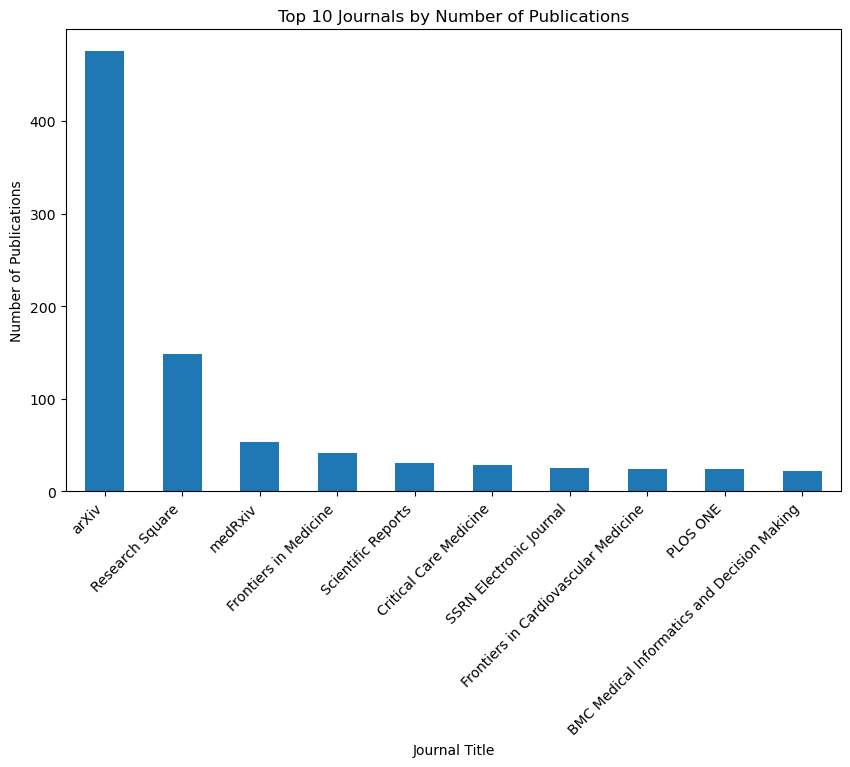

In [51]:
# Assuming the MIMIC_pubs dataframe is named 'MIMIC_pubs'
# Group the dataframe by 'journal.title' and count the number of publications for each journal
journal_counts = MIMIC_pubs.groupby('journal.title').size()

# Sort the journals by the number of publications in descending order
sorted_journal_counts = journal_counts.sort_values(ascending=False)

# Get the top 10 journals
top_10_journals = sorted_journal_counts.head(10)

print("MIMIC Top 10 journals by the number of publications:")
print(top_10_journals)

import pandas as pd
import matplotlib.pyplot as plt
# Group the dataframe by 'journal.title' and count the number of publications for each journal
journal_counts = MIMIC_pubs.groupby('journal.title').size()

# Sort the journals by the number of publications in descending order
sorted_journal_counts = journal_counts.sort_values(ascending=False)

# Get the top 10 journals
top_10_journals = sorted_journal_counts.head(10)
print("Top3 count:",475+148+53,"Top 3 journal %",(475+148+53)/len(MIMIC_pubs), "MIMIC totle pubs", len(MIMIC_pubs))
# Create a bar plot of the top 10 journals
fig, ax = plt.subplots(figsize=(10, 6))
top_10_journals.plot(kind='bar', ax=ax)
ax.set_ylabel('Number of Publications')
ax.set_xlabel('Journal Title')
ax.set_title('Top 10 Journals by Number of Publications')
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


Control Top 10 journals by the number of publications:
journal.title
Annual International Conference of the IEEE Engineering in Medicine and Biology Society (EMBC)    99
PLOS ONE                                                                                          71
Scientific Reports                                                                                68
Critical Care Medicine                                                                            68
Journal of Clinical Monitoring and Computing                                                      44
Computers in Biology and Medicine                                                                 35
Computer Methods and Programs in Biomedicine                                                      32
Sensors                                                                                           32
Critical Care                                                                                     32
Artificial Intelligenc

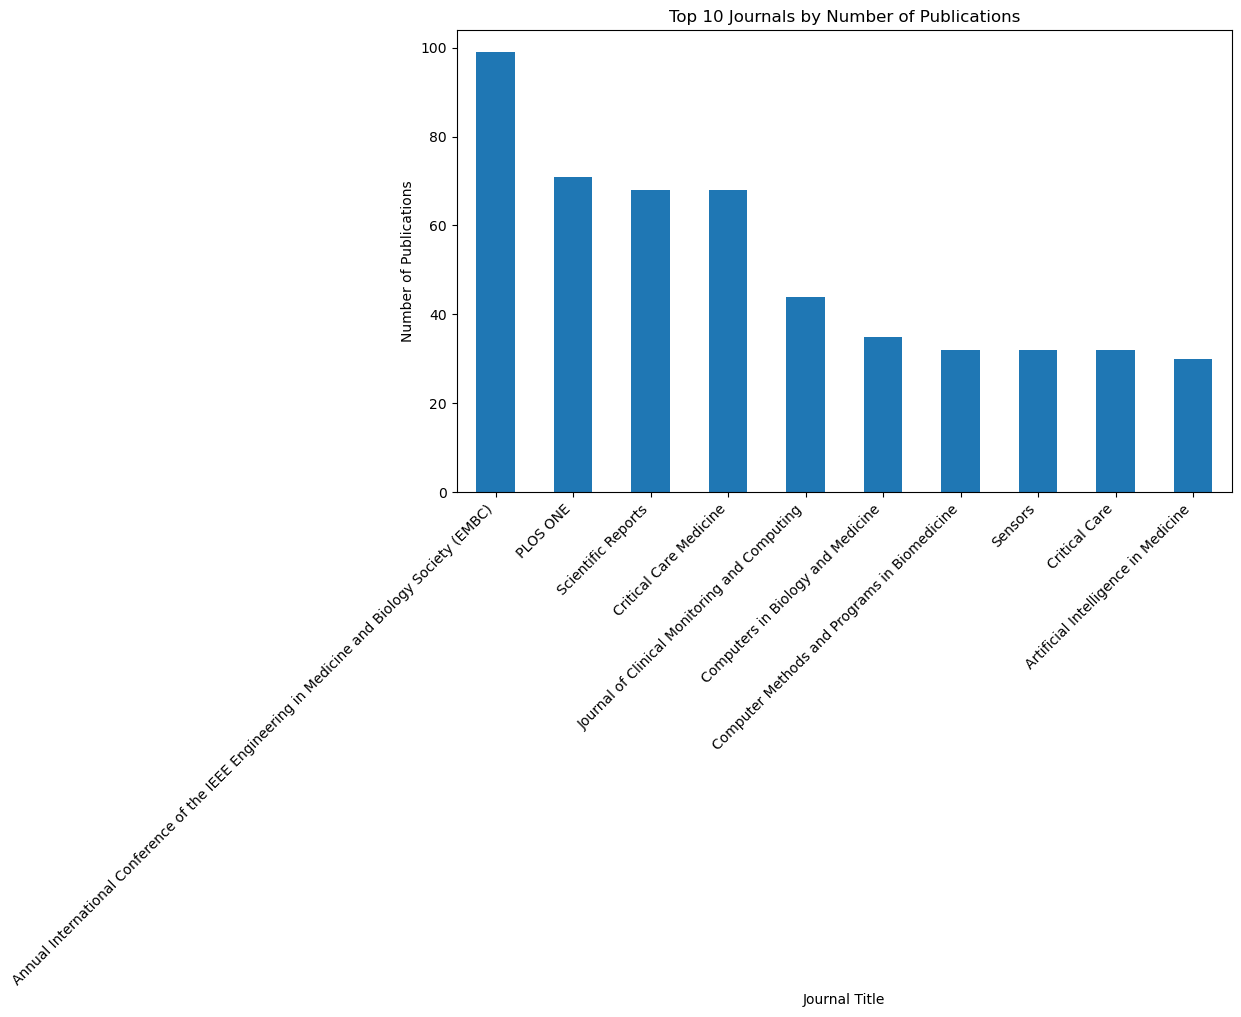

In [52]:

# Group the dataframe by 'journal.title' and count the number of publications for each journal
journal_counts = Control_pubs.groupby('journal.title').size()

# Sort the journals by the number of publications in descending order
sorted_journal_counts = journal_counts.sort_values(ascending=False)

# Get the top 10 journals
top_10_journals = sorted_journal_counts.head(10)

print("Control Top 10 journals by the number of publications:")
print(top_10_journals)
print("Top3 count:",99+71+68,"Top 3 journal %",(99+71+68)/len(Control_pubs), "MIMIC totle pubs", len(Control_pubs))

# Group the dataframe by 'journal.title' and count the number of publications for each journal
journal_counts = Control_pubs.groupby('journal.title').size()

# Sort the journals by the number of publications in descending order
sorted_journal_counts = journal_counts.sort_values(ascending=False)

# Get the top 10 journals
top_10_journals = sorted_journal_counts.head(10)

# Create a bar plot of the top 10 journals
fig, ax = plt.subplots(figsize=(10, 6))
top_10_journals.plot(kind='bar', ax=ax)
ax.set_ylabel('Number of Publications')
ax.set_xlabel('Journal Title')
ax.set_title('Top 10 Journals by Number of Publications')
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

In [53]:

# Create a boolean column indicating if a paper has a missing affiliation for any author
MIMIC_affli['missing_affiliation'] = MIMIC_affli['aff_country'].isna() | MIMIC_affli['aff_country_code'].isna()

# Group by publication and aggregate the 'missing_affiliation' column with 'any' function
grouped_affiliations = MIMIC_affli.groupby('pub_id')['missing_affiliation'].agg('any').reset_index(name='any_missing_affiliation')

# Filter the papers with non-missing affiliations
papers_with_non_missing_affiliations = grouped_affiliations[grouped_affiliations['any_missing_affiliation'] == False]

# Calculate the percentage of papers with at least one author with a missing affiliation
num_papers = len(grouped_affiliations)
num_papers_with_missing_affiliation = grouped_affiliations['any_missing_affiliation'].sum()
percentage_papers_with_missing_affiliation = (num_papers_with_missing_affiliation / num_papers) * 100

print(f"Number of papers with non-missing affiliations: {len(papers_with_non_missing_affiliations)}")
print(f"{percentage_papers_with_missing_affiliation:.2f}% of papers had at least one author with a missing affiliation.")


Number of papers with non-missing affiliations: 1487
11.06% of papers had at least one author with a missing affiliation.


In [54]:
MIMIC_affli.pub_id.value_counts()

MIMIC_author_counts = MIMIC_affli.groupby('pub_id')['researcher_id'].nunique()

# Filter the results to get the number of papers with only one author
MIMIC_single_author_papers = MIMIC_author_counts[MIMIC_author_counts == 1].count()

print(f"MIMIC Number of papers with only one author: {MIMIC_single_author_papers}")

MIMIC Number of papers with only one author: 104


In [55]:
Control_affli.pub_id.value_counts()


# Assuming 'df' is your DataFrame with 'pub_id' and 'researcher_id' columns
# Group by 'pub_id' and count the number of unique authors for each publication
Control_author_counts = Control_affli.groupby('pub_id')['researcher_id'].nunique()

# Filter the results to get the number of papers with only one author
Control_single_author_papers = Control_author_counts[Control_author_counts == 1].count()

print(f"Control Number of papers with only one author: {Control_single_author_papers}")

Control Number of papers with only one author: 178


In [56]:
Control_affli.income_class.value_counts()

income_class
High income            19798
Upper middle income     4278
Lower middle income      742
Low income                14
Name: count, dtype: int64

### Any LMIC count

In [57]:
# Please only run this cell once 
# Convert 'Yes' and 'No' in 'LMIC' column to 1 and 0
MIMIC_affli['LMIC'] = MIMIC_affli['LMIC'].map({'Yes': 1, 'No': 0}) # Note this line should be only use one time
# Convert 'Yes' and 'No' in 'LMIC' column to 1 and 0
Control_affli['LMIC'] = Control_affli['LMIC'].map({'Yes': 1, 'No': 0})


In [60]:

# Group the dataframe by 'pub_id' and count the number of authors for each publication
author_counts = MIMIC_affli.groupby('pub_id').size()

# Get the 'pub_id' of papers with two or more authors
papers_with_two_or_more_authors = author_counts[author_counts >= 2].index
print("MIMIC papers with two or more authors", len(papers_with_two_or_more_authors))
# Filter the dataframe to keep only papers with two or more authors
MIMIC_affli_two_or_more_authors = MIMIC_affli[MIMIC_affli['pub_id'].isin(papers_with_two_or_more_authors)]

# Count the number of LMIC authors for each paper
lmic_counts = MIMIC_affli_two_or_more_authors.groupby('pub_id')['LMIC'].sum()

# Determine the papers with multiple LMIC authors
papers_with_multiple_lmic_authors = lmic_counts[lmic_counts >= 2].index

# Calculate the percentage
percentage_multiple_lmic_authors = (len(papers_with_multiple_lmic_authors) / len(papers_with_two_or_more_authors)) * 100

print(f"MIMIC  Among articles with two authors or more, {percentage_multiple_lmic_authors:.2f}% papers had multiple LMIC authors.")

# Repeat the same process for the Control_affli DataFrame
# Group the dataframe by 'pub_id' and count the number of authors for each publication
author_counts = Control_affli.groupby('pub_id').size()

# Get the 'pub_id' of papers with two or more authors
control_papers_with_two_or_more_authors = author_counts[author_counts >= 2].index
print("Control papers with two or more authors", len(control_papers_with_two_or_more_authors))
# Filter the dataframe to keep only papers with two or more authors
Control_affli_two_or_more_authors = Control_affli[Control_affli['pub_id'].isin(control_papers_with_two_or_more_authors)]

# Count the number of LMIC authors for each paper
Control_lmic_counts = Control_affli_two_or_more_authors.groupby('pub_id')['LMIC'].sum()

# Determine the papers with multiple LMIC authors
control_papers_with_multiple_lmic_authors = Control_lmic_counts[Control_lmic_counts >= 2].index

# Calculate the percentage
control_percentage_multiple_lmic_authors = (len(control_papers_with_multiple_lmic_authors) / len(control_papers_with_two_or_more_authors)) * 100

print(f"Control  Among articles with two authors or more, {control_percentage_multiple_lmic_authors:.2f}% papers had multiple LMIC authors.")

# Repeat the same process for the Control_affli DataFrame
# After calculating percentages for both MIMIC and Control
# Create binary arrays representing whether each paper in each group has multiple LMIC authors (1) or not (0)
mimic_papers_binary = np.array([1 if pub_id in papers_with_multiple_lmic_authors else 0 for pub_id in MIMIC_affli_two_or_more_authors['pub_id'].unique()])
print(mimic_papers_binary)
control_papers_binary = np.array([1 if pub_id in control_papers_with_multiple_lmic_authors else 0 for pub_id in Control_affli_two_or_more_authors['pub_id'].unique()])

# Perform the one-tailed t-test
t_stat, p_value = ttest_ind(mimic_papers_binary, control_papers_binary, equal_var=False, alternative='greater')

# Since this is a one-tailed test, the p-value should be halved (as ttest_ind returns a two-tailed p-value)
p_value /= 2

print(f"One-tailed T-test result: T-statistic = {t_stat:.4f}, P-value = {p_value:.4f}")

MIMIC papers with two or more authors 1647
MIMIC  Among articles with two authors or more, 8.32% papers had multiple LMIC authors.
Control papers with two or more authors 2739
Control  Among articles with two authors or more, 5.51% papers had multiple LMIC authors.
[0 1 0 ... 0 0 0]
One-tailed T-test result: T-statistic = 3.4699, P-value = 0.0001


In [61]:
print("Control")
Control_lmic_count = Control_affli[Control_affli['LMIC'] == 1].groupby('pub_id').agg({'LMIC': 'count'}).reset_index()
print("LMIC>0",len(Control_lmic_count[Control_lmic_count.LMIC>0]))
print("MIMIC")
MIMIC_lmic_count = MIMIC_affli[MIMIC_affli['LMIC'] == 1].groupby('pub_id').agg({'LMIC': 'count'}).reset_index()
print("LMIC>0",len(MIMIC_lmic_count[MIMIC_lmic_count.LMIC>0]))

Control
LMIC>0 182
MIMIC
LMIC>0 156


In [63]:
IncomeByPub = MIMIC_affli[['pub_id','income_class_num']].groupby(['pub_id']).agg([ 'count','mean']).reset_index()

In [64]:
MIMIC_affli[['pub_id','income_class_num']].groupby(['pub_id']).mean().reset_index()

,pub_id,income_class_num
0,pub.1001792778,4.0
1,pub.1002353037,4.0
2,pub.1003040860,4.0
3,pub.1006639384,4.0
4,pub.1007449969,3.0
...,...,...
1667,pub.1155896423,2.0
1668,pub.1155904804,3.0
1669,pub.1156298472,2.0
1670,pub.1156298670,2.8


In [66]:
# Determine unique 'pub_id's with at least one LMIC author
lmic_pubs = MIMIC_affli[MIMIC_affli['LMIC'] == 1]['pub_id'].nunique()

# Calculate the total number of unique 'pub_id's
total_pubs = MIMIC_affli['pub_id'].nunique()

# Calculate the percentage
percentage_lmic = (lmic_pubs / total_pubs) * 100

print(f"Overall, {percentage_lmic:.2f}% of MIMIC articles in the considered set had at least one LMIC author.")

# Repeat the same for Control dataset

lmic_pubs_control = Control_affli[Control_affli['LMIC'] == 1]['pub_id'].nunique()
total_pubs_control = Control_affli['pub_id'].nunique()
percentage_lmic_control = (lmic_pubs_control / total_pubs_control) * 100

print(f"Overall, {percentage_lmic_control:.2f}% of Control articles in the considered set had at least one LMIC author.")

# Concatenate the two DataFrames
combined_affli = pd.concat([MIMIC_affli, Control_affli])

# Determine unique 'pub_id's with at least one LMIC author
lmic_pubs_combined = combined_affli[combined_affli['LMIC'] == 1]['pub_id'].nunique()

# Calculate the total number of unique 'pub_id's
total_pubs_combined = combined_affli['pub_id'].nunique()

# Calculate the percentage
percentage_lmic_combined = (lmic_pubs_combined / total_pubs_combined) * 100

print(f"Overall, {percentage_lmic_combined:.2f}% of articles in the combined set had at least one LMIC author.")


Overall, 9.33% of MIMIC articles in the considered set had at least one LMIC author.
Overall, 6.33% of Control articles in the considered set had at least one LMIC author.
Overall, 7.43% of articles in the combined set had at least one LMIC author.


In [73]:
MIMIC_affli.groupby('pub_id').filter(lambda x: len(x) >= 2)

,Unnamed: 0,aff_city,aff_city_id,aff_country,aff_country_code,aff_id,aff_name,aff_raw_affiliation,aff_state,aff_state_code,...,last_name,year,gender,gender_ints,income_class,income_class_num,LMIC,Author_Order,full_name,missing_affiliation
0,0,Guangzhou,1809858.0,China,CN,grid.412601.0,First Affiliated Hospital of Jinan University,"Department of Neurology, The First Affiliated ...",NaN,NaN,...,Huang,2022,male,0.0,Upper middle income,3.0,0,First,Xiaxuan Huang,False
1,1,Guangzhou,1809858.0,China,CN,grid.412601.0,First Affiliated Hospital of Jinan University,"Department of Neurology, The First Affiliated ...",NaN,NaN,...,Yuan,2022,female,1.0,Upper middle income,3.0,0,Middle,Shiqi Yuan,False
2,2,Guangzhou,1809858.0,China,CN,grid.412601.0,First Affiliated Hospital of Jinan University,"Department of Neurology, The First Affiliated ...",NaN,NaN,...,Ling,2022,female,1.0,Upper middle income,3.0,0,Middle,Yitong Ling,False
3,3,Guangzhou,1809858.0,China,CN,grid.412601.0,First Affiliated Hospital of Jinan University,"Department of Neurology, The First Affiliated ...",NaN,NaN,...,Tan,2022,female,1.0,Upper middle income,3.0,0,Middle,Shanyuan Tan,False
4,4,Guangzhou,1809858.0,China,CN,grid.412601.0,First Affiliated Hospital of Jinan University,"Department of Clinical Research, The First Aff...",NaN,NaN,...,Huang,2022,male,0.0,Upper middle income,3.0,0,First,Tao Huang,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13962,13962,Borstel,2945988.0,Germany,DE,grid.418187.3,Research Center Borstel - Leibniz Lung Center,"Division of Structural Biochemistry, Departmen...",NaN,NaN,...,Moran,2010,male,0.0,High income,4.0,0,Last,Anthony P. Moran,False
13963,13963,Fort Collins,5577147.0,United States,US,grid.47894.36,Colorado State University,"Department of Microbiology, Immunology and Pat...",Colorado,US-CO,...,Moran,2010,male,0.0,High income,4.0,0,Last,Anthony P. Moran,False
13964,13964,Brisbane,2174003.0,Australia,AU,grid.1022.1,Griffith University,"Institute for Glycomics, Gold Coast Campus, Gr...",Queensland,AU-QLD,...,Moran,2010,male,0.0,High income,4.0,0,Last,Anthony P. Moran,False
13965,13965,Galway,2964180.0,Ireland,IE,grid.6142.1,"National University of Ireland, Galway","School of Natural Sciences, National Universit...",NaN,NaN,...,Moran,2010,male,0.0,High income,4.0,0,Last,Anthony P. Moran,False


In [71]:
print("MIMIC/eICU")
papers_with_two_or_more_authors = MIMIC_affli.groupby('pub_id').filter(lambda x: len(x) >= 2)
print("papers with two or more authors",len(papers_with_two_or_more_authors))
print("papers count ", len(MIMIC_affli.groupby('pub_id')))
# Group papers by publication id and count the number of LMIC authors per paper
lmic_counts = papers_with_two_or_more_authors[papers_with_two_or_more_authors['LMIC'] == 1].groupby('pub_id')['LMIC'].count()
print("total lmic", len(lmic_counts))

# Calculate the percentage of papers with multiple LMIC authors
papers_with_multiple_lmic_authors = lmic_counts[lmic_counts >= 2].index
percentage_multiple_lmic_authors = (len(papers_with_multiple_lmic_authors) / len(papers_with_two_or_more_authors['pub_id'].unique())) * 100

# Determine papers where the first author is affiliated with a LMIC country
first_authors = papers_with_two_or_more_authors.groupby('pub_id').first()

papers_with_first_author_lmic = first_authors[first_authors['LMIC'] == 1].index
print("first_authors",len(papers_with_first_author_lmic))
# Calculate the percentage of papers where the first author is affiliated with a LMIC country
percentage_first_author_lmic = (len(papers_with_first_author_lmic) / len(papers_with_two_or_more_authors['pub_id'].unique())) * 100

print(f"Among articles with two authors or more, {percentage_multiple_lmic_authors:.2f}% had multiple LMIC authors.")
print(f"Additionally, the first author was affiliated with a LMIC country in {percentage_first_author_lmic:.2f}% of papers with two or more authors.")


MIMIC/eICU
papers with two or more authors 13942
papers count  1672
total lmic 154
first_authors 118
Among articles with two authors or more, 8.32% had multiple LMIC authors.
Additionally, the first author was affiliated with a LMIC country in 7.16% of papers with two or more authors.


In [74]:
print("Control")
papers_with_two_or_more_authors = Control_affli.groupby('pub_id').filter(lambda x: len(x) >= 2)

# Group papers by publication id and count the number of LMIC authors per paper
lmic_counts = papers_with_two_or_more_authors[papers_with_two_or_more_authors['LMIC'] == 1].groupby('pub_id')['LMIC'].count()
print("total lmic", len(lmic_counts))
# Calculate the percentage of papers with multiple LMIC authors
papers_with_multiple_lmic_authors = lmic_counts[lmic_counts >= 2].index
percentage_multiple_lmic_authors = (len(papers_with_multiple_lmic_authors) / len(papers_with_two_or_more_authors['pub_id'].unique())) * 100

# Determine papers where the first author is affiliated with a LMIC country
first_authors = papers_with_two_or_more_authors.groupby('pub_id').first()

papers_with_first_author_lmic = first_authors[first_authors['LMIC'] == 1].index
print("first_authors",len(papers_with_first_author_lmic))
# Calculate the percentage of papers where the first author is affiliated with a LMIC country
percentage_first_author_lmic = (len(papers_with_first_author_lmic) / len(papers_with_two_or_more_authors['pub_id'].unique())) * 100

print(f"Among articles with two authors or more, {percentage_multiple_lmic_authors:.2f}% had multiple LMIC authors.")
print(f"Additionally, the first author was affiliated with a LMIC country in {percentage_first_author_lmic:.2f}% of papers with two or more authors.")


Control
total lmic 175
first_authors 131
Among articles with two authors or more, 5.51% had multiple LMIC authors.
Additionally, the first author was affiliated with a LMIC country in 4.78% of papers with two or more authors.


## Statistics for LMIC analyses

In [65]:
MIMIC_first_authors = MIMIC_affli.groupby('pub_id').first().reset_index()
MIMIC_last_authors = MIMIC_affli.groupby('pub_id').last().reset_index()
MIMIC_first_author_lmic_count = MIMIC_first_authors[MIMIC_first_authors['LMIC'] == 1].shape[0]
MIMIC_last_author_lmic_count = MIMIC_last_authors[MIMIC_last_authors['LMIC'] == 1].shape[0]

MIMIC_lmic_authors = MIMIC_affli[MIMIC_affli['LMIC'] == 1]

# Drop duplicate 'pub_id' values to count unique publications
MIMIC_unique_lmic_papers = MIMIC_lmic_authors.drop_duplicates(subset='pub_id')

# Count the number of unique publications with at least one LMIC author
MIMIC_num_lmic_papers = len(MIMIC_unique_lmic_papers)

print(f"MIMIC Number of publications with any author from LMIC: {MIMIC_num_lmic_papers}")
print(f"MIMIC Number of first authors from LMIC: {MIMIC_first_author_lmic_count}")
print(f"MIMIC Number of last authors from LMIC: {MIMIC_last_author_lmic_count}")
print(f"MIMIC Number of papers with only one author: {MIMIC_single_author_papers}")

MIMIC Number of publications with any author from LMIC: 156
MIMIC Number of first authors from LMIC: 120
MIMIC Number of last authors from LMIC: 120
MIMIC Number of papers with only one author: 104


In [66]:
Control_first_authors = Control_affli.groupby('pub_id').first().reset_index()
Control_last_authors = Control_affli.groupby('pub_id').last().reset_index()
Control_first_author_lmic_count = Control_first_authors[Control_first_authors['LMIC'] == 1].shape[0]
Control_last_author_lmic_count = Control_last_authors[Control_last_authors['LMIC'] == 1].shape[0]

Control_lmic_authors = Control_affli[Control_affli['LMIC'] == 1]

# Drop duplicate 'pub_id' values to count unique publications
Control_unique_lmic_papers = Control_lmic_authors.drop_duplicates(subset='pub_id')

# Count the number of unique publications with at least one LMIC author
Control_num_lmic_papers = len(Control_unique_lmic_papers)

print(f"Control Number of publications with any author from LMIC: {Control_num_lmic_papers}")
print(f"Control Number of first authors from LMIC: {Control_first_author_lmic_count}")
print(f"Control Number of last authors from LMIC: {Control_last_author_lmic_count}")
print(f"Control Number of papers with only one author: {Control_single_author_papers}")

Control Number of publications with any author from LMIC: 182
Control Number of first authors from LMIC: 138
Control Number of last authors from LMIC: 127
Control Number of papers with only one author: 178


In [67]:
#Overall
print(156/1672)
print(120/1672)
print(120/1672)
print(182/2877)
print(138/2877)
print(127/2877)

0.09330143540669857
0.07177033492822966
0.07177033492822966
0.06326034063260341
0.047966631908237745
0.044143204727146335


In [68]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
# Number of successes (LMIC authors) in each group
counts = np.array([156, 182])

# Total number of observations in each group
nobs = np.array([1672, 2877])

# Perform the Z-test with the alternative hypothesis stating that the proportion in the MIMIC/eICU group is greater than the control group
z_stat, p_value = proportions_ztest(counts, nobs, alternative='larger')

print(f"Z-stat: {z_stat:.4f}")
print(f"P-value: {p_value:.4f}")

Z-stat: 3.7249
P-value: 0.0001


In [73]:
import numpy as np
from scipy.stats import ttest_ind

# Number of successes (LMIC authors) in each group
counts = np.array([156, 182])

# Total number of observations in each group
nobs = np.array([1672, 2877])

# Creating arrays that represent successes and failures for each group
group1 = np.array([1]*counts[0] + [0]*(nobs[0] - counts[0]))
group2 = np.array([1]*counts[1] + [0]*(nobs[1] - counts[1]))

# Perform the two-sample t-test for independent samples
t_stat, p_value = ttest_ind(group1, group2, equal_var=False, alternative='greater')

print(f"T-stat: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")


T-stat: 3.5594
P-value: 0.0002


In [115]:
# Filter the DataFrame to get rows with LMIC authors
lmic_authors = MIMIC_affli[MIMIC_affli['LMIC'] == 1]

# Group by 'pub_id' and count the number of LMIC authors for each publication
mimic_lmic_author_counts = lmic_authors.groupby('pub_id')['researcher_id'].nunique()

# Filter the results to get the number of papers with two or more LMIC authors
multiple_lmic_papers = mimic_lmic_author_counts[mimic_lmic_author_counts >= 2].count()

# Group by 'pub_id' and count the total number of authors for each publication
total_author_counts = MIMIC_affli.groupby('pub_id')['researcher_id'].nunique()

# Filter the results to get the number of papers with two or more authors
two_or_more_authors_papers = total_author_counts[total_author_counts >= 2].count()

# Calculate the percentage of papers with multiple LMIC authors among those with two or more authors
percentage_multiple_lmic = (multiple_lmic_papers / two_or_more_authors_papers) * 100

print(f"MIMIC Percentage of papers with multiple LMIC authors among those with two or more authors: {percentage_multiple_lmic:.2f}%")


MIMIC Percentage of papers with multiple LMIC authors among those with two or more authors: 7.94%


In [114]:
# Filter the DataFrame to get rows with LMIC authors
lmic_authors = Control_affli[Control_affli['LMIC'] == 1]

# Group by 'pub_id' and count the number of LMIC authors for each publication
control_lmic_author_counts = lmic_authors.groupby('pub_id')['researcher_id'].nunique()

# Filter the results to get the number of papers with two or more LMIC authors
multiple_lmic_papers = control_lmic_author_counts[control_lmic_author_counts >= 2].count()

# Group by 'pub_id' and count the total number of authors for each publication
total_author_counts = Control_affli.groupby('pub_id')['researcher_id'].nunique()

# Filter the results to get the number of papers with two or more authors
two_or_more_authors_papers = total_author_counts[total_author_counts >= 2].count()

# Calculate the percentage of papers with multiple LMIC authors among those with two or more authors
percentage_multiple_lmic = (multiple_lmic_papers / two_or_more_authors_papers) * 100

print(f"Control Percentage of papers with multiple LMIC authors among those with two or more authors: {percentage_multiple_lmic:.2f}%")


Control Percentage of papers with multiple LMIC authors among those with two or more authors: 5.42%


In [82]:
# Group by 'pub_id' and count the total number of authors for each publication
total_author_counts = MIMIC_affli.groupby('pub_id')['researcher_id'].nunique()

# Filter the results to get the number of papers with two or more authors
two_or_more_authors_papers = total_author_counts[total_author_counts >= 2].index

# Get a new DataFrame with only papers with two or more authors
two_or_more_authors_df = MIMIC_affli[MIMIC_affli['pub_id'].isin(two_or_more_authors_papers)]

# Sort the DataFrame by 'pub_id' and reset the index
sorted_df = two_or_more_authors_df.sort_values(by='pub_id').reset_index(drop=True)

# Get the first and  author for each publication
first_authors = sorted_df.groupby('pub_id').first()
last_authors = sorted_df.groupby('pub_id').last()
# Filter the DataFrame to get rows with LMIC first authors
lmic_first_authors = first_authors[first_authors['LMIC'] == 1]
lmic_last_authors = last_authors[last_authors['LMIC']==1]
# Count the number of papers with the first author from LMIC
num_MIMIC_lmic_first_authors = len(lmic_first_authors)
num_MIMIC_lmic_last_authors = len(lmic_last_authors)
# Count the total number of papers with two or more authors
total_papers_two_or_more_authors = len(two_or_more_authors_papers)

# Calculate the percentage of papers with the first author from LMIC among those with two or more authors
percentage_lmic_first_authors = (num_MIMIC_lmic_first_authors / total_papers_two_or_more_authors) * 100
percentage_lmic_last_authors = (num_MIMIC_lmic_last_authors / total_papers_two_or_more_authors) * 100

print(f"MIMIC Percentage of papers with two or more authors having the first author from LMIC: {percentage_lmic_first_authors:.2f}%")
print(f"MIMIC Percentage of papers with two or more authors having the last author from LMIC: {percentage_lmic_last_authors:.2f}%")

MIMIC Percentage of papers with two or more authors having the first author from LMIC: 7.14%
MIMIC Percentage of papers with two or more authors having the last author from LMIC: 7.07%


In [83]:

# Group by 'pub_id' and count the total number of authors for each publication
total_author_counts = Control_affli.groupby('pub_id')['researcher_id'].nunique()

# Filter the results to get the number of papers with two or more authors
two_or_more_authors_papers = total_author_counts[total_author_counts >= 2].index

# Get a new DataFrame with only papers with two or more authors
two_or_more_authors_df = Control_affli[Control_affli['pub_id'].isin(two_or_more_authors_papers)]

# Sort the DataFrame by 'pub_id' and reset the index
sorted_df = two_or_more_authors_df.sort_values(by='pub_id').reset_index(drop=True)

# Get the first and  author for each publication
first_authors = sorted_df.groupby('pub_id').first()
last_authors = sorted_df.groupby('pub_id').last()
# Filter the DataFrame to get rows with LMIC first authors
Control_lmic_first_authors = first_authors[first_authors['LMIC'] == 1]
Control_lmic_last_authors = last_authors[last_authors['LMIC']==1]
# Count the number of papers with the first author from LMIC
num_Control_lmic_first_authors = len(Control_lmic_first_authors)
num_Control_lmic_last_authors = len(Control_lmic_last_authors)
# Count the total number of papers with two or more authors
total_papers_two_or_more_authors = len(two_or_more_authors_papers)

# Calculate the percentage of papers with the first author from LMIC among those with two or more authors
percentage_lmic_first_authors = (num_Control_lmic_first_authors / total_papers_two_or_more_authors) * 100
percentage_lmic_last_authors = (num_Control_lmic_last_authors / total_papers_two_or_more_authors) * 100

print(f"Control Percentage of papers with two or more authors having the first author from LMIC: {percentage_lmic_first_authors:.3f}%")
print(f"Control Percentage of papers with two or more authors having the last author from LMIC: {percentage_lmic_last_authors:.3f}%")

Control Percentage of papers with two or more authors having the first author from LMIC: 4.593%
Control Percentage of papers with two or more authors having the last author from LMIC: 4.744%


In [84]:

# Create binary arrays for first and last authors in MIMIC and Control groups
mimic_first_authors_binary = np.array([1 if pub_id in lmic_first_authors.index else 0 for pub_id in two_or_more_authors_df['pub_id'].unique()])
mimic_last_authors_binary = np.array([1 if pub_id in lmic_last_authors.index else 0 for pub_id in two_or_more_authors_df['pub_id'].unique()])

control_first_authors_binary = np.array([1 if pub_id in Control_lmic_first_authors.index else 0 for pub_id in two_or_more_authors_df['pub_id'].unique()])
control_last_authors_binary = np.array([1 if pub_id in Control_lmic_last_authors.index else 0 for pub_id in two_or_more_authors_df['pub_id'].unique()])

# Perform the two-sample t-test for first authors
t_stat_first, p_value_first = ttest_ind(mimic_first_authors_binary, control_first_authors_binary, equal_var=False)

# Perform the two-sample t-test for last authors
t_stat_last, p_value_last = ttest_ind(mimic_last_authors_binary, control_last_authors_binary, equal_var=False)

print(f"T-test for first authors: T-statistic = {t_stat_first:.4f}, P-value = {p_value_first:.4f}")
print(f"T-test for last authors: T-statistic = {t_stat_last:.4f}, P-value = {p_value_last:.4f}")


T-test for first authors: T-statistic = -11.3060, P-value = 0.0000
T-test for last authors: T-statistic = -11.4989, P-value = 0.0000


In [85]:
# Concatenate the two DataFrames
combined_affli = pd.concat([MIMIC_affli, Control_affli])

# Determine unique 'pub_id's with at least one LMIC author
lmic_pubs_combined = combined_affli[combined_affli['LMIC'] == 1]['pub_id'].nunique()

# Calculate the total number of unique 'pub_id's
total_pubs_combined = combined_affli['pub_id'].nunique()

# Calculate the percentage
percentage_lmic_combined = (lmic_pubs_combined / total_pubs_combined) * 100

print(f"Overall, {percentage_lmic_combined:.2f}% of articles in the combined set had at least one LMIC author.")
# Gender intersection

# Filter the dataframe to keep only those papers with non-missing gender and LMIC status information
combined_affli_filtered = combined_affli.dropna(subset=['gender', 'LMIC'])

# Group the dataframe by 'pub_id' and check if there is at least one woman author and at least one LMIC-based author for each paper
papers_with_woman_and_lmic_authors = combined_affli_filtered.groupby('pub_id').apply(lambda x: (x['gender'].str.lower() == 'female').any() and (x['LMIC']==1).any())

# Calculate the number of papers with at least one woman and one LMIC-based researcher among the authors
papers_count = papers_with_woman_and_lmic_authors.sum()

# Calculate the total number of papers with non-missing gender and LMIC status information
total_papers = len(papers_with_woman_and_lmic_authors)

# Calculate the percentage
percentage_woman_and_lmic_authors = (papers_count / total_papers) * 100

print(f"combined Among the {total_papers} papers with non-missing gender and LMIC status information, {percentage_woman_and_lmic_authors:.2f}% had at least one woman and one LMIC-based researcher among the authors.")

Overall, 7.43% of articles in the combined set had at least one LMIC author.
combined Among the 4229 papers with non-missing gender and LMIC status information, 5.04% had at least one woman and one LMIC-based researcher among the authors.


In [86]:
# Combine MIMIC and Control datasets
combined_affli = pd.concat([MIMIC_affli, Control_affli])

# Group by 'pub_id' and count the total number of authors for each publication
total_author_counts = combined_affli.groupby('pub_id').size()

# Filter the results to get the number of papers with two or more authors
two_or_more_authors_papers = total_author_counts[total_author_counts >= 2].index

# Get a new DataFrame with only papers with two or more authors
two_or_more_authors_df = combined_affli[combined_affli['pub_id'].isin(two_or_more_authors_papers)]

# Get the first and last author for each publication
first_authors = two_or_more_authors_df.groupby('pub_id').first()
last_authors = two_or_more_authors_df.groupby('pub_id').last()

# Filter the DataFrame to get rows with LMIC first authors and last authors
lmic_first_authors = first_authors[first_authors['LMIC'] == 1]
lmic_last_authors = last_authors[last_authors['LMIC'] == 1]

# Count the number of papers with the first author and the last author from LMIC
num_lmic_first_authors = lmic_first_authors['LMIC'].count()
num_lmic_last_authors = lmic_last_authors['LMIC'].count()

# Calculate the percentage of papers with the first author and the last author from LMIC among those with two or more authors
percentage_lmic_first_authors = (num_lmic_first_authors / total_author_counts.count()) * 100
percentage_lmic_last_authors = (num_lmic_last_authors / total_author_counts.count()) * 100

print(f"Combined Percentage of papers with two or more authors having the first author from LMIC: {percentage_lmic_first_authors:.2f}%")
print(f"Combined Percentage of papers with two or more authors having the last author from LMIC: {percentage_lmic_last_authors:.2f}%")


Combined Percentage of papers with two or more authors having the first author from LMIC: 5.47%
Combined Percentage of papers with two or more authors having the last author from LMIC: 5.23%


In [87]:


# Filter the dataframe to keep only those papers with non-missing gender and LMIC status information
MIMIC_affli_filtered = MIMIC_affli.dropna(subset=['gender', 'LMIC'])

# Group the dataframe by 'pub_id' and check if there is at least one woman author and at least one LMIC-based author for each paper
papers_with_woman_and_lmic_authors = MIMIC_affli_filtered.groupby('pub_id').apply(lambda x: (x['gender'].str.lower() == 'female').any() and (x['LMIC']==1).any())

# Calculate the number of papers with at least one woman and one LMIC-based researcher among the authors
papers_count = papers_with_woman_and_lmic_authors.sum()

# Calculate the total number of papers with non-missing gender and LMIC status information
total_papers = len(papers_with_woman_and_lmic_authors)

# Calculate the percentage
percentage_woman_and_lmic_authors = (papers_count / total_papers) * 100

print(f"MIMIC Among the {total_papers} papers with non-missing gender and LMIC status information, {percentage_woman_and_lmic_authors:.2f}% had at least one woman and one LMIC-based researcher among the authors.")
# Filter the dataframe to keep only those papers with non-missing gender and LMIC status information
Control_affli_filtered = Control_affli.dropna(subset=['gender', 'LMIC'])

# Group the dataframe by 'pub_id' and check if there is at least one woman author and at least one LMIC-based author for each paper
papers_with_woman_and_lmic_authors = Control_affli_filtered.groupby('pub_id').apply(lambda x: (x['gender'].str.lower() == 'female').any() and (x['LMIC']==1).any())

# Calculate the number of papers with at least one woman and one LMIC-based researcher among the authors
papers_count = papers_with_woman_and_lmic_authors.sum()

# Calculate the total number of papers with non-missing gender and LMIC status information
total_papers = len(papers_with_woman_and_lmic_authors)

# Calculate the percentage
percentage_woman_and_lmic_authors = (papers_count / total_papers) * 100

print(f"Control Among the {total_papers} papers with non-missing gender and LMIC status information, {percentage_woman_and_lmic_authors:.2f}% had at least one woman and one LMIC-based researcher among the authors.")

MIMIC Among the 1603 papers with non-missing gender and LMIC status information, 6.11% had at least one woman and one LMIC-based researcher among the authors.
Control Among the 2626 papers with non-missing gender and LMIC status information, 4.38% had at least one woman and one LMIC-based researcher among the authors.


In [88]:

# Proportions provided
mimic_proportion = 6.11 / 100
control_proportion = 4.38 / 100

# Total number of papers with non-missing gender and LMIC status information
mimic_total_papers = 1672
control_total_papers = 2877

# Calculate the number of papers with at least one woman and one LMIC-based researcher among the authors
mimic_papers_count = int(mimic_total_papers * mimic_proportion)
control_papers_count = int(control_total_papers * control_proportion)

# Perform the two-proportion Z-test
z_stat, p_value = proportions_ztest([mimic_papers_count, control_papers_count],
                                    [mimic_total_papers, control_total_papers],
                                    alternative='larger')

print(f"one-sided Two-proportion Z-test: p-value = {p_value:.4f}")

one-sided Two-proportion Z-test: p-value = 0.0052


In [89]:
import numpy as np
from scipy.stats import ttest_ind

# Proportions provided
mimic_proportion = 6.11 / 100
control_proportion = 4.38 / 100

# Total number of papers with non-missing gender and LMIC status information
mimic_total_papers = 1672
control_total_papers = 2877

# Calculate the number of papers with at least one woman and one LMIC-based researcher among the authors
mimic_papers_count = int(mimic_total_papers * mimic_proportion)
control_papers_count = int(control_total_papers * control_proportion)

# Create arrays representing the outcomes for each group
mimic_papers = np.array([1] * mimic_papers_count + [0] * (mimic_total_papers - mimic_papers_count))
control_papers = np.array([1] * control_papers_count + [0] * (control_total_papers - control_papers_count))

# Perform the two-sample t-test for independent samples
t_stat, p_value = ttest_ind(mimic_papers, control_papers, equal_var=False, alternative='greater')

print(f"One-sided Two-proportion T-test: p-value = {p_value:.4f}")


One-sided Two-proportion T-test: p-value = 0.0069


In [90]:
# # Combine both DataFrames: MIMIC/eICU and control datasets
# combined_affli = pd.concat([MIMIC_affli, Control_affli])



# # Filter the dataframe to keep only those papers with non-missing gender and LMIC status information
# Combined_affli_filtered = combined_affli.dropna(subset=['gender', 'LMIC'])

# # Group the dataframe by 'pub_id' and check if there is at least one woman author and at least one LMIC-based author for each paper
# papers_with_woman_and_lmic_authors = Combined_affli_filtered.groupby('pub_id').apply(lambda x: (x['gender'].str.lower() == 'female').any() and (x['LMIC']=='Yes').any())

# # Calculate the number of papers with at least one woman and one LMIC-based researcher among the authors
# papers_count = papers_with_woman_and_lmic_authors.sum()

# # Calculate the total number of papers with non-missing gender and LMIC status information
# total_papers = len(papers_with_woman_and_lmic_authors)

# # Calculate the percentage
# percentage_woman_and_lmic_authors = (papers_count / total_papers) * 100

# print(f"Combined Among the {total_papers} papers with non-missing gender and LMIC status information, {percentage_woman_and_lmic_authors:.2f}% had at least one woman and one LMIC-based researcher among the authors.")


In [129]:
# # Assuming you have two dataframes: MIMIC_affli and Control_affli. If not, just use one.
# combined_df = pd.concat([MIMIC_affli, Control_affli])

# # Filter the dataframe to keep only those papers with non-missing gender and LMIC status information
# filtered_df = combined_df.dropna(subset=['gender', 'LMIC'])

# # Group the dataframe by 'pub_id' and check if there is at least one woman author and at least one LMIC-based author for each paper
# papers_with_woman_and_lmic_authors = filtered_df.groupby('pub_id').apply(lambda x: (x['gender'].str.lower() == 'female').any() and (x['LMIC'] == 'Yes').any())

# # Calculate the number of papers meeting the criteria
# papers_count = papers_with_woman_and_lmic_authors.sum()

# # Calculate the total number of papers with non-missing gender and LMIC status information
# total_papers = len(papers_with_woman_and_lmic_authors)

# # Calculate the percentage
# percentage_woman_and_lmic_authors = (papers_count / total_papers) * 100

# print(f"Combined Among the {total_papers} papers with non-missing gender and LMIC status information, ({papers_count}){percentage_woman_and_lmic_authors:.2f}% had at least one woman and one LMIC-based researcher among the authors.")


In [101]:
MIMIC_affli[(MIMIC_affli['gender']=='female')&( MIMIC_affli['LMIC']=='Yes')]

,Unnamed: 0,aff_city,aff_city_id,aff_country,aff_country_code,aff_id,aff_name,aff_raw_affiliation,aff_state,aff_state_code,...,last_name,year,gender,gender_ints,income_class,income_class_num,LMIC,Author_Order,full_name,missing_affiliation


In [91]:
MIMIC_affli['LMIC'].value_counts()

LMIC
0    13312
1      655
Name: count, dtype: int64

In [92]:
from scipy.stats import ttest_ind

# Assuming get_papers_with_woman_and_lmic function and dataframes MIMIC_affli and Control_affli are already defined

# Calculate for the MIMIC dataset
mimic_papers = get_papers_with_woman_and_lmic(MIMIC_affli)
mimic_total = mimic_papers.shape[0]
mimic_count = mimic_papers.sum()

# Calculate for the control group
control_papers = get_papers_with_woman_and_lmic(Control_affli)  # Replace with the name of your control group dataframe
control_total = control_papers.shape[0]
control_count = control_papers.sum()

# Create arrays representing the outcomes for each group
mimic_outcomes = np.array([1]*mimic_count + [0]*(mimic_total - mimic_count))
control_outcomes = np.array([1]*control_count + [0]*(control_total - control_count))

# Perform the two-sample t-test for independent samples
t_stat, p_value = ttest_ind(mimic_outcomes, control_outcomes, equal_var=False)

mimic_percentage = (mimic_count / mimic_total) * 100
control_percentage = (control_count / control_total) * 100

print(f"In the MIMIC dataset comprising {mimic_total} papers, {mimic_count} ({mimic_percentage:.2f}%) featured at least one woman and at least one LMIC-based researcher among the authors. In contrast, in the control group comprising {control_total} papers, only {control_count} ({control_percentage:.2f}%) included both a woman and an LMIC-based researcher. This difference, as determined by a t-test, is statistically significant (p={p_value:.4f}).")


NameError: name 'get_papers_with_woman_and_lmic' is not defined

In [93]:
# Count the number of unique pubs in both dataframes
num_common_pubs = len(set(MIMIC_affli['pub_id']).intersection(Control_affli['pub_id']))

print("Number of common pubs: ", num_common_pubs)


Number of common pubs:  0


In [94]:
# Calculate the difference between the two groups
percentage_difference = (mimic_proportion - control_proportion) * 100

print(f"The difference between the two groups is {percentage_difference:.2f} percentage points.")


The difference between the two groups is 1.73 percentage points.


### Sensitivity Analyses

In [95]:
from statsmodels.stats.proportion import proportions_ztest
def sensitivity_analysis(total_treatment_papers, known_treatment_papers, treatment_counts, control_counts, num_scenarios=10):
    # Calculate the proportion of LMIC authors in the known data for each group
    treatment_proportion = treatment_counts[0] / sum(treatment_counts)
    control_proportion = control_counts[0] / sum(control_counts)

    # Calculate the number of papers with missing author information for each group
    missing_treatment_papers = total_treatment_papers - known_treatment_papers
    missing_control_papers = total_control_papers - known_control_papers
    missing_papers = missing_treatment_papers + missing_control_papers

    p_values = []

    for i in range(num_scenarios + 1):
        # Vary the proportion of LMIC authors in the missing data
        treatment_missing = int(missing_papers * treatment_proportion * i / num_scenarios)
        control_missing = int(missing_papers * control_proportion * i / num_scenarios)

        # Calculate the adjusted counts of LMIC authors for each group
        adjusted_treatment_counts = treatment_counts[0] + treatment_missing
        adjusted_control_counts = control_counts[0] + control_missing

        # Perform the one-sided Z-test with the alternative hypothesis stating that the proportion in the MIMIC/eICU group is greater than the control group
        z_stat, p_value = proportions_ztest([adjusted_treatment_counts, adjusted_control_counts],
                                            [known_treatment_papers + missing_treatment_papers, known_control_papers + missing_control_papers],
                                            alternative='larger')

        p_values.append(p_value)

    return p_values


In [96]:
MIMIC_affli.pub_id.nunique()
# Control_pubs.id.nunique()

1672

In [97]:
total_treatment_papers = MIMIC_pubs.id.nunique()
total_control_papers = Control_pubs.id.nunique()
known_treatment_papers = MIMIC_affli.pub_id.nunique()
known_control_papers = Control_affli.pub_id.nunique()
n_MIMIC_lmic = len(MIMIC_lmic_count)
n_Control_lmic = len(Control_lmic_count)
treatment_counts = (n_MIMIC_lmic, known_treatment_papers - n_MIMIC_lmic)
control_counts = (n_Control_lmic, known_treatment_papers - n_Control_lmic)

p_values = sensitivity_analysis(total_treatment_papers, known_treatment_papers,
                                treatment_counts, control_counts)

for i, p_value in enumerate(p_values):
    print(f"Scenario {i}: p-value = {p_value:.4f}")


Scenario 0: p-value = 0.2277
Scenario 1: p-value = 0.2231
Scenario 2: p-value = 0.2187
Scenario 3: p-value = 0.2143
Scenario 4: p-value = 0.2071
Scenario 5: p-value = 0.2031
Scenario 6: p-value = 0.1991
Scenario 7: p-value = 0.2080
Scenario 8: p-value = 0.1888
Scenario 9: p-value = 0.1851
Scenario 10: p-value = 0.1816


In [98]:
#  Set data
# Replace these values with your data
total_treatment_papers = len(MIMIC_pubs)
total_control_papers = len(Control_pubs)
known_treatment_papers = MIMIC_affli.pub_id.nunique()
known_control_papers = Control_affli.pub_id.nunique()
first_treatment_counts = (num_MIMIC_lmic_first_authors, known_treatment_papers - num_MIMIC_lmic_first_authors)
first_control_counts = (num_Control_lmic_first_authors, known_control_papers - num_Control_lmic_first_authors)
last_treatment_counts = (num_MIMIC_lmic_last_authors, known_treatment_papers - num_MIMIC_lmic_last_authors)
last_control_counts = (num_Control_lmic_last_authors , known_control_papers - num_Control_lmic_last_authors)
n_MIMIC_lmic = len(MIMIC_lmic_count)
n_Control_lmic = len(Control_lmic_count)
treatment_counts = (n_MIMIC_lmic, known_treatment_papers - n_MIMIC_lmic)
control_counts = (n_Control_lmic, known_treatment_papers - n_Control_lmic)


In [99]:
# from statsmodels.stats.proportion import proportions_ztest

def sensitivity_analysis_all_missing_lmic(total_treatment_papers, known_treatment_papers, treatment_counts, control_counts):
    # Calculate the number of papers with missing author information for each group
    missing_treatment_papers = total_treatment_papers - known_treatment_papers
    missing_control_papers = total_control_papers - known_control_papers

    # Assume all the missing authors are from LMIC and add them to the known LMIC author counts
    adjusted_treatment_counts = treatment_counts[0] + missing_treatment_papers
    adjusted_control_counts = control_counts[0] + missing_control_papers
    print("adjusted treatment  count : ",adjusted_treatment_counts)
    print("adjusted treatment proportion %: ", adjusted_treatment_counts/total_treatment_papers*100)
    print("adjusted control count % :", adjusted_control_counts)
    print("adjusted control proportion: ", adjusted_control_counts/total_treatment_papers*100)
    # Perform the one-sided Z-test with the alternative hypothesis stating that the proportion in the treatment group is greater than the control group
    z_stat, p_value = proportions_ztest([adjusted_treatment_counts, adjusted_control_counts],
                                        [total_treatment_papers, total_control_papers],
                                        alternative='larger')

    return p_value, z_stat

overall_p_value,overall_z_stat = sensitivity_analysis_all_missing_lmic(total_treatment_papers, known_treatment_papers,
                                                treatment_counts, control_counts)

first_p_value , first_z_stat= sensitivity_analysis_all_missing_lmic(total_treatment_papers, known_treatment_papers,
                                                first_treatment_counts, first_control_counts)
last_p_value, last_z_stat = sensitivity_analysis_all_missing_lmic(total_treatment_papers, known_treatment_papers,
                                                last_treatment_counts, last_control_counts)

print(f"overall All missing authors from LMIC sensitivity analysis: p-value = {overall_p_value:.10f}")
print(f"first author All missing authors from LMIC sensitivity analysis: p-value = {first_p_value:.10f}")
print(f"last author All missing authors from LMIC sensitivity analysis: p-value = {last_p_value:.10f}")
print("overall_z:", overall_z_stat)
print("first_z:", first_z_stat)
print("last_z:", last_z_stat)

adjusted treatment  count :  791
adjusted treatment proportion %:  34.28695275249242
adjusted control count % : 217
adjusted control proportion:  9.4061551798873
adjusted treatment  count :  742
adjusted treatment proportion %:  32.16298222800174
adjusted control count % : 157
adjusted control proportion:  6.805374945817079
adjusted treatment  count :  741
adjusted treatment proportion %:  32.11963589076723
adjusted control count % : 161
adjusted control proportion:  6.978760294755093
overall All missing authors from LMIC sensitivity analysis: p-value = 0.0000000000
first author All missing authors from LMIC sensitivity analysis: p-value = 0.0000000000
last author All missing authors from LMIC sensitivity analysis: p-value = 0.0000000000
overall_z: 24.38890624121113
first_z: 25.436894931166147
last_z: 25.231906916459092


In [101]:
def sensitivity_analysis_impute(total_treatment_papers, known_treatment_papers, treatment_counts, control_counts):
    # Calculate the proportion of LMIC authors in the known data for each group
    treatment_proportion = treatment_counts[0] / sum(treatment_counts)
    control_proportion = control_counts[0] / sum(control_counts)

    # Calculate the number of papers with missing author information for each group
    missing_treatment_papers = total_treatment_papers - known_treatment_papers
    missing_control_papers = total_control_papers - known_control_papers

    # Impute the missing data by distributing the LMIC and non-LMIC authors based on the known proportions for both groups
    imputed_treatment_counts = int(missing_treatment_papers * treatment_proportion)
    imputed_control_counts = int(missing_control_papers * control_proportion)

    # Calculate the adjusted counts of LMIC authors for each group
    adjusted_treatment_counts = treatment_counts[0] + imputed_treatment_counts
    adjusted_control_counts = control_counts[0] + imputed_control_counts
    print("adjusted treatment  count : ",adjusted_treatment_counts)
    print("adjusted treatment proportion %: ", adjusted_treatment_counts/total_treatment_papers*100)
    print("adjusted control count % :", adjusted_control_counts)
    print("adjusted control proportion: ", adjusted_control_counts/total_treatment_papers*100)
    # Perform the one-sided Z-test with the alternative hypothesis stating that the proportion in the treatment group is greater than the control group
    z_stat, p_value = proportions_ztest([adjusted_treatment_counts, adjusted_control_counts],
                                        [total_treatment_papers, total_control_papers],
                                        alternative='larger')

    return p_value

overall_p_value = sensitivity_analysis_impute(total_treatment_papers, known_treatment_papers,
                                                treatment_counts, control_counts)
first_p_value = sensitivity_analysis_impute(total_treatment_papers, known_treatment_papers,
                                                first_treatment_counts, first_control_counts)
last_p_value = sensitivity_analysis_impute(total_treatment_papers, known_treatment_papers,
                                                last_treatment_counts, last_control_counts)

print(f"impute missing from distribution of auhtors from LMIC sensitivity analysis: p-value = {overall_p_value:.5f}")
print(f"first author impute missing from distribution of auhtors from LMIC sensitivity analysis: p-value = {first_p_value:.5f}")
print(f"last author impute missing from distribution of auhtors from LMIC sensitivity analysis: p-value = {last_p_value:.5f}")



adjusted treatment  count :  215
adjusted treatment proportion %:  9.319462505418292
adjusted control count % : 185
adjusted control proportion:  8.019072388383181
adjusted treatment  count :  147
adjusted treatment proportion %:  6.371911573472041
adjusted control count % : 123
adjusted control proportion:  5.331599479843954
adjusted treatment  count :  146
adjusted treatment proportion %:  6.328565236237537
adjusted control count % : 127
adjusted control proportion:  5.504984828781968
impute missing from distribution of auhtors from LMIC sensitivity analysis: p-value = 0.00003
first author impute missing from distribution of auhtors from LMIC sensitivity analysis: p-value = 0.00025
last author impute missing from distribution of auhtors from LMIC sensitivity analysis: p-value = 0.00076


In [102]:

def sensitivity_analysis_all_missing_not_lmic(total_treatment_papers, known_treatment_papers, treatment_counts, control_counts):
    # Since all missing authors are assumed to be not from LMIC, use the known LMIC author counts as they are
    adjusted_treatment_counts = treatment_counts[0]
    adjusted_control_counts = control_counts[0]
    print("adjusted treatment  count : ",adjusted_treatment_counts)
    print("adjusted treatment proportion %: ", adjusted_treatment_counts/total_treatment_papers*100)
    print("adjusted control count % :", adjusted_control_counts)
    print("adjusted control proportion: ", adjusted_control_counts/total_treatment_papers*100)
    # Perform the one-sided Z-test with the alternative hypothesis stating that the proportion in the treatment group is greater than the control group
    z_stat, p_value = proportions_ztest([adjusted_treatment_counts, adjusted_control_counts],
                                        [total_treatment_papers, total_control_papers],
                                        alternative='larger')

    return p_value

overall_p_value = sensitivity_analysis_all_missing_not_lmic(total_treatment_papers, known_treatment_papers,
                                                treatment_counts, control_counts)
first_p_value = sensitivity_analysis_all_missing_not_lmic(total_treatment_papers, known_treatment_papers,
                                                first_treatment_counts, first_control_counts)
last_p_value = sensitivity_analysis_all_missing_not_lmic(total_treatment_papers, known_treatment_papers,
                                                last_treatment_counts, last_control_counts)

print(f"overall All missing authors not from LMIC sensitivity analysis: p-value = {overall_p_value:.5f}")
print(f"first author All missing authors not from LMIC sensitivity analysis: p-value = {first_p_value:.5f}")
print(f"last author All missing authors not from LMIC sensitivity analysis: p-value = {last_p_value:.5f}")

adjusted treatment  count :  156
adjusted treatment proportion %:  6.762028608582575
adjusted control count % : 182
adjusted control proportion:  7.88903337667967
adjusted treatment  count :  107
adjusted treatment proportion %:  4.638058084091894
adjusted control count % : 122
adjusted control proportion:  5.28825314260945
adjusted treatment  count :  106
adjusted treatment proportion %:  4.59471174685739
adjusted control count % : 126
adjusted control proportion:  5.461638491547465
overall All missing authors not from LMIC sensitivity analysis: p-value = 0.22770
first author All missing authors not from LMIC sensitivity analysis: p-value = 0.21605
last author All missing authors not from LMIC sensitivity analysis: p-value = 0.32055


In [105]:
from scipy.stats import ttest_ind
import numpy as np

def sensitivity_analysis_all_missing_not_lmic(total_treatment_papers, known_treatment_papers, treatment_counts, control_counts):
    # Since all missing authors are assumed to be not from LMIC, use the known LMIC author counts as they are
    adjusted_treatment_counts = treatment_counts[0]
    adjusted_control_counts = control_counts[0]
    print("adjusted treatment count: ", adjusted_treatment_counts)
    print("adjusted treatment proportion %: ", adjusted_treatment_counts / total_treatment_papers * 100)
    print("adjusted control count: ", adjusted_control_counts)
    print("adjusted control proportion: ", adjusted_control_counts / total_treatment_papers * 100)
    
    # Create arrays representing the counts for each group
    treatment_array = np.full(total_treatment_papers, adjusted_treatment_counts / total_treatment_papers)
    control_array = np.full(total_treatment_papers, adjusted_control_counts / total_treatment_papers)

    # Perform the two-sided t-test
    t_stat, p_value = ttest_ind(treatment_array, control_array, equal_var=False)  # Assuming unequal variance

    return t_stat,p_value

# Example usage
overall_t,overall_p_value = sensitivity_analysis_all_missing_not_lmic(total_treatment_papers, known_treatment_papers, treatment_counts, control_counts)
first_t,first_p_value = sensitivity_analysis_all_missing_not_lmic(total_treatment_papers, known_treatment_papers, first_treatment_counts, first_control_counts)
last_t,last_p_value = sensitivity_analysis_all_missing_not_lmic(total_treatment_papers, known_treatment_papers, last_treatment_counts, last_control_counts)

print(f"Overall All missing authors not from LMIC sensitivity analysis: p-value = {overall_p_value:.5f}")
print(f"First author All missing authors not from LMIC sensitivity analysis: p-value = {first_p_value:.5f}")
print(f"Last author All missing authors not from LMIC sensitivity analysis: p-value = {last_p_value:.5f}")


adjusted treatment count:  156
adjusted treatment proportion %:  6.762028608582575
adjusted control count:  182
adjusted control proportion:  7.88903337667967
adjusted treatment count:  107
adjusted treatment proportion %:  4.638058084091894
adjusted control count:  122
adjusted control proportion:  5.28825314260945
adjusted treatment count:  106
adjusted treatment proportion %:  4.59471174685739
adjusted control count:  126
adjusted control proportion:  5.461638491547465
Overall All missing authors not from LMIC sensitivity analysis: p-value = 0.00000
First author All missing authors not from LMIC sensitivity analysis: p-value = 0.00000
Last author All missing authors not from LMIC sensitivity analysis: p-value = 0.00000


/Users/chenyuli/anaconda3/envs/py3/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [111]:
import numpy as np
from scipy.stats import ttest_ind

def sensitivity_analysis_all_missing_not_lmic(total_treatment_papers, known_treatment_papers, treatment_counts, control_counts):
    # Since all missing authors are assumed to be not from LMIC, use the known LMIC author counts as they are
    adjusted_treatment_counts = treatment_counts[0]
    adjusted_control_counts = control_counts[0]
    print("adjusted treatment count: ", adjusted_treatment_counts)
    print("adjusted treatment proportion %: ", adjusted_treatment_counts / total_treatment_papers * 100)
    print("adjusted control count: ", adjusted_control_counts)
    print("adjusted control proportion: ", adjusted_control_counts / total_treatment_papers * 100)

    # Creating arrays that represent successes and failures for each group
    treatment_group = np.array([1] * adjusted_treatment_counts + [0] * (total_treatment_papers - adjusted_treatment_counts))
    control_group = np.array([1] * adjusted_control_counts + [0] * (total_treatment_papers - adjusted_control_counts))

    # Perform the one-sided T-test with the alternative hypothesis stating that the mean in the treatment group is greater than the control group
    t_stat, p_value = ttest_ind(treatment_group, control_group, equal_var=False, alternative='greater')

    return p_value

# Example usage of the function (You'll need to define the variables used here)
overall_p_value = sensitivity_analysis_all_missing_not_lmic(total_treatment_papers, known_treatment_papers,
                                                treatment_counts, control_counts)
first_p_value = sensitivity_analysis_all_missing_not_lmic(total_treatment_papers, known_treatment_papers,
                                                first_treatment_counts, first_control_counts)
last_p_value = sensitivity_analysis_all_missing_not_lmic(total_treatment_papers, known_treatment_papers,
                                                last_treatment_counts, last_control_counts)

print(f"overall All missing authors not from LMIC sensitivity analysis: p-value = {overall_p_value:.5f}")
print(f"first author All missing authors not from LMIC sensitivity analysis: p-value = {first_p_value:.5f}")
print(f"last author All missing authors not from LMIC sensitivity analysis: p-value = {last_p_value:.5f}")


adjusted treatment count:  156
adjusted treatment proportion %:  6.762028608582575
adjusted control count:  182
adjusted control proportion:  7.88903337667967
adjusted treatment count:  107
adjusted treatment proportion %:  4.638058084091894
adjusted control count:  122
adjusted control proportion:  5.28825314260945
adjusted treatment count:  106
adjusted treatment proportion %:  4.59471174685739
adjusted control count:  126
adjusted control proportion:  5.461638491547465
overall All missing authors not from LMIC sensitivity analysis: p-value = 0.92906
first author All missing authors not from LMIC sensitivity analysis: p-value = 0.84532
last author All missing authors not from LMIC sensitivity analysis: p-value = 0.91103


### Intersection of Gender and LMIC 

In [112]:

# Merge the DataFrames
merged_df = pd.merge(MIMIC_affli, MIMIC_pubs, left_on='pub_id', right_on='id', how='left')

# Filter the dataset
filtered_df = merged_df.dropna(subset=['pct_female_real', 'LMIC'])

# Count papers with at least one woman (using pct_female_real >= 0.5) and one LMIC-based researcher among the authors
grouped = filtered_df.groupby('pub_id').agg({'pct_female_real': lambda x: (x >= 0.5).any(), 'LMIC': lambda x: (x == 1).any()})
papers_with_woman_and_lmic = grouped[(grouped['pct_female_real']) & (grouped['LMIC'])].shape[0]

# Calculate the percentage
total_papers = filtered_df['pub_id'].nunique()
percentage = (papers_with_woman_and_lmic / total_papers) * 100

print(f"Percentage of MIMIC/eICU papers with at least one woman and one LMIC-based researcher among the authors: {percentage:.2f}%")


Percentage of MIMIC/eICU papers with at least one woman and one LMIC-based researcher among the authors: 2.74%


In [143]:
# Merge the DataFrames
merged_df = pd.merge(MIMIC_affli, MIMIC_pubs, left_on='pub_id', right_on='id', how='left')

# Filter the dataset
filtered_df = merged_df.dropna(subset=['gender', 'LMIC'])

# Count papers with at least one woman (using gender == 'F') and one LMIC-based researcher among the authors
grouped = filtered_df.groupby('pub_id').agg({'gender': lambda x: (x == 'female').any(), 'LMIC': lambda x: (x == 'Yes').any()})
papers_with_woman_and_lmic = grouped[(grouped['gender']) & (grouped['LMIC'])].shape[0]

# Calculate the percentage
total_papers = filtered_df['pub_id'].nunique()
percentage = (papers_with_woman_and_lmic / total_papers) * 100

print(f"Percentage of MIMIC/eICU papers with at least one woman and one LMIC-based researcher among the authors: {percentage:.2f}%")


Percentage of MIMIC/eICU papers with at least one woman and one LMIC-based researcher among the authors: 0.00%


# 3. MSI analyses

## Minority Serving Institutions Present in Affiliation Data

* The fuzzy matching pipeline below was developed to discern the associations between authors and specific Minority Serving Institutions (MSIs).

In [5]:
# author affiliation data for the compare and control datasets
# controlData = pd.read_csv("GuruData/control_group_affils(7).csv", encoding='utf-8')
# compareData = pd.read_csv("GuruData/mimic_affils(7).csv", encoding='utf-8') # checked the shape 
controlData = Control_affli.copy()
compareData = MIMIC_affli.copy()
# below are the datasets containing Minority Serving Institutions for the year 2020 and 2022
minorityList2020 = pd.read_csv("GuruData/2020_Minority_Serving_Institutions-1.csv")
minorityList2022 = pd.read_csv("GuruData/2022 CMSI Eligibility Matrix .csv")

In [6]:
# dropping all the NA values
minorityList2022['Institution Name'].dropna()

0              Aaniiih Nakoda College
1              Adams State University
2                  Adelphi University
3             AdventHealth University
4            Alabama A & M University
                    ...              
858        Woodland Community College
859          World Mission University
860          World Mission University
861    Xavier University of Louisiana
862             Yakima Valley College
Name: Institution Name, Length: 863, dtype: object

In [8]:
def isfloat(num):
    try:
        float(num)
        return True
    except ValueError:
        return False

In [9]:
msi = []

# compiling MSI type information for the 2022 list
for i in range(865):
        if(isfloat(minorityList2022.loc[i]['ANNH']) == False and minorityList2022.loc[i]['ANNH'] == 'Yes'):
            msi.append('ANNH')
        elif(isfloat(minorityList2022.loc[i]['AANAPISI']) == False and minorityList2022.loc[i]['AANAPISI'] == 'Yes'):
            msi.append('AANAPISI')
        elif(isfloat(minorityList2022.loc[i]['HSI']) == False and minorityList2022.loc[i]['HSI'] == 'Yes'):
            msi.append('HSI')
        elif(isfloat(minorityList2022.loc[i]['NASNTI']) == False and minorityList2022.loc[i]['NASNTI'] == 'Yes'):
            msi.append('NASNTI')
        elif(isfloat(minorityList2022.loc[i]['PBI']) == False and minorityList2022.loc[i]['PBI'] == 'Yes'):
            msi.append('PBI')
        elif(isfloat(minorityList2022.loc[i]['HBCU']) == False and minorityList2022.loc[i]['HBCU'] == 'Yes'):
            msi.append('HBCU')
        elif(isfloat(minorityList2022.loc[i]['TCU']) == False and minorityList2022.loc[i]['TCU'] == 'Yes'):
            msi.append('TCU')
        else:
            msi.append('No MSI Type')
    

In [10]:
#appending the MSI type information to the 2022 file
minorityList2022['MSI Type'] = msi
#understanding the number of unique institutions (non-exact matches) in each respective file
uniqueInstitutions = set(minorityList2020['Institution']).intersection(set(minorityList2022['Institution Name']))
print(uniqueInstitutions)
# print(minorityList2020['Institution'].isin(minorityList2022['Institution Name']).value_counts())
minorityList2022['Institution Name'].isin(minorityList2020['Institution']).value_counts()

{'College of Lake County', 'Reedley College', 'San Bernardino Valley College', 'South Louisiana Community College', 'Central Georgia Technical College', 'Nova Southeastern University', 'Bladen Community College', 'West Virginia State University', 'Northern Marianas College', 'Palomar College', 'San Joaquin Delta College', 'Bluefield State College', 'Phoenix College', 'Los Angeles Harbor College', 'Capital Community College', 'National University', 'McLennan Community College', 'Dine College', 'East Mississippi Community College', 'California College San Diego', 'Community College of Denver', 'Chaminade University of Honolulu', 'Los Angeles Mission College', 'Benedict College', 'University of Hawaii at Hilo', "Saint Martin's University", 'University of Alaska Southeast', 'Atlanta Metropolitan State College', 'Morton College', 'Shelton State Community College', 'Florida International University', 'Orange Coast College', 'Western Texas College', 'Nevada State College', "St. Mary's Univers

Institution Name
True     496
False    369
Name: count, dtype: int64

### MSI List Similiarity Analysis (2020 vs 2022):
* A total of 496 institutions were shared by the two sources (exact matches)
    * Some more institutions are shared but their institution name is formatted differently

#### Using fuzzy match (threshold value of 97) percent to guage a more accurate approximation

In [151]:
def matchMSIFuzzy(x):
    for i in range(862):
        if(isfloat(x) == False and fuzz.partial_ratio(minorityList2022.loc[i]['Institution Name'], x) > 97):
            return "Yes"
    return "No"

In [152]:
minorityList2020['isIn2022'] = minorityList2020['Institution'].apply(matchMSIFuzzy)

### MSI List Similiarity Analysis w/ Fuzzy Match (2020 vs 2022):
* A total of 566 institutions were shared by the two sources

In [155]:
# dropping all the affiliation data that doesn't originate within the United States or has no country affilation
comparI = compareData[compareData['aff_country'] != 'United States'].index
compareData = compareData.drop(comparI)
controlI = controlData[controlData['aff_country'] != 'United States'].index
controlData = controlData.drop(controlI)
compareData['aff_country'].dropna()
controlData['aff_country'].dropna()

6        United States
38       United States
39       United States
40       United States
41       United States
             ...      
25660    United States
25661    United States
25662    United States
25663    United States
25664    United States
Name: aff_country, Length: 7654, dtype: object

#### Fuzzy Matching Affiliation Data for Compare and Control Groups with MSI Lists

In [156]:
# fuzzy matching methods for both 2020 and 2022 lists

def fuzzTest(x):
    for i in range(774):
        if(isfloat(x) == False and fuzz.partial_ratio(minorityList2020.loc[i]['Institution'], x) > 97):
            return minorityList2020.loc[i]['Institution']
    return "Not Minority"

def fuzzTest2(x):
    for i in range(862):
        if(isfloat(x) == False and fuzz.partial_ratio(minorityList2022.loc[i]['Institution Name'], x) > 97):
            return minorityList2022.loc[i]['Institution Name']
    return "Not Minority"



In [157]:
# applying the method to the affiliation name column
compareData['isMinority_2020'] = compareData['aff_name'].apply(fuzzTest)
controlData['isMinority_2020'] = controlData['aff_name'].apply(fuzzTest)
compareData['isMinority_2022'] = compareData['aff_name'].apply(fuzzTest2)
controlData['isMinority_2022'] = controlData['aff_name'].apply(fuzzTest2)

#### Understand the distribution 

In [158]:

compareMinorityValues2020 = compareData['isMinority_2020'].value_counts().to_frame()
controlMinorityValues2020 = controlData['isMinority_2020'].value_counts().to_frame()
compareMinorityValues2022 = compareData['isMinority_2022'].value_counts().to_frame()
controlMinorityValues2022 = controlData['isMinority_2022'].value_counts().to_frame()

In [159]:
print(controlData['isMinority_2020'].value_counts())
print(compareData['isMinority_2022'].value_counts())

isMinority_2020
Not Minority                                                              7031
Cheyney University of Pennsylvania                                         173
Vanguard University of Southern California                                  87
University of Washington - Seattle                                          77
University of Minnesota - Twin Cities                                       40
University of Arizona (The)                                                 39
University of California, Davis                                             34
University of California, Irvine                                            28
University of Texas Health Science Center at San Antonio                    27
University of Connecticut - Hartford Campus                                 14
Rutgers, the State University of New Jersey                                 13
Pennsylvania State University - Penn State Abington                         11
Georgia State University            

### Understanding MSI types 
* The OIC supports colleges and universities designated as minority serving institutions:

    * Asian American Native American Pacific Islander-Serving Institutions (ANNAPISIs)
    * Alaska Native and Native Hawaiian Serving Institutions (ANNHs)
    * Historically Black Colleges & Universities (HBCUs)
    * Hispanic Serving institutions (HSIs)
    * Native American-Serving Non-Tribal Institutions (NASNTIs)
    * Predominantly Black Institutions (PBIs)
    * Tribal Colleges and Universities (TCUs)


In [160]:
# Type
def typeInfo(x):
    if (x != 'Not Minority'):
        indexArray = minorityList2020[minorityList2020['Institution']== x].index.values
        index = indexArray[0]
        return minorityList2020.loc[index]['Type']
    return 'Not Minority'
def typeInfo2(x):
    if (x != 'Not Minority'):
        indexArray = minorityList2022[minorityList2022['Institution Name']== x].index.values
        index = indexArray[0]
        return minorityList2022.loc[index]['Type']
    return 'Not Minority'

In [161]:
compareData['Type2020'] = compareData['isMinority_2020'].apply(typeInfo)
controlData['Type2020'] = controlData['isMinority_2020'].apply(typeInfo)
compareData['Type2022'] = compareData['isMinority_2022'].apply(typeInfo2)
controlData['Type2022'] = controlData['isMinority_2022'].apply(typeInfo2)


In [162]:
# MSI Type
def msiInfo(x):
    if (x != 'Not Minority'):
        indexArray = minorityList2020[minorityList2020['Institution'] == x].index.values
        index = indexArray[0]
        return minorityList2020.loc[index]['MSI Type']
    return 'Not Minority'
def msiInfo2(x):
    if (x != 'Not Minority'):
        indexArray = minorityList2022[minorityList2022['Institution Name'] == x].index.values
        index = indexArray[0]
        return minorityList2022.loc[index]['MSI Type']
    return 'Not Minority'

In [163]:
compareData['MSI Type2020'] = compareData['isMinority_2020'].apply(msiInfo)
controlData['MSI Type2020'] = controlData['isMinority_2020'].apply(msiInfo)
compareData['MSI Type2022'] = compareData['isMinority_2022'].apply(msiInfo2)
controlData['MSI Type2022'] = controlData['isMinority_2022'].apply(msiInfo2)

### Cleaning Process
* To confirm the accuracy of the mapping between institutional affiliations and their potential MSI status, we performed manual verification on a subset of the results yielded by the aforementioned fuzzy-matching process. In cases when an author’s institutional affiliation was incorrectly mapped to an MSI, we rectified the mistake manually. Verification was limited to reducing false positives, i.e., we only determined institutional affiliations that were erroneously linked with MSIs.
* This allowed us to understand which MSIs appeared in the datasets 
    * Used this information in gender and first vs last author pipelines

## Gender Distributions of Authors Affiliated w/ MSIs

In [28]:
remControl = pd.read_csv("./GuruData/controlUnionType.csv")
remMIMIC= pd.read_csv("./GuruData/mimicUnionType.csv")
mimic20 = pd.read_csv("./GuruData/minorityMimiccorrectx(d).csv")
mimic22 = pd.read_csv("./GuruData/minorityMimiccorrectx(d).csv")
control20 = pd.read_csv("./GuruData/minoritycontolcorrectx(d).csv")
control22 = pd.read_csv("./GuruData/minoritycontolcorrectx(d).csv")
# mimicaffils = pd.read_csv("./GuruData/mimic_affils(7).csv") # checked
mimicaffils = MIMIC_affli.copy()
# controlaffils = pd.read_csv("./GuruData/control_group_affils(7).csv") # checked with Control_affli
# controlGender = pd.read_csv("./GuruData/control_group_affils_v2.csv") #  wasn't used in later analysis 

#### Data Cleaning 

In [165]:
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

In [166]:
remControl.head()

,controlUnion,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,NaN,Institution,isMinority_Union,MSI_Type
1,0.0,Not Minority,7750,No MSI Type
2,1.0,University of Washington - Seattle,66,AANAPISI
3,2.0,University of Minnesota - Twin Cities,48,AANAPISI
4,3.0,The University of Texas at Austin,35,AANAPISI


In [167]:
remMIMIC = remMIMIC.iloc[: , 1:]
remMIMIC = remMIMIC.rename(columns=remMIMIC.iloc[0])
remControl = remControl.iloc[: , 1:]
remControl = remControl.rename(columns=remControl.iloc[0])
remMIMIC = remMIMIC.iloc[1: , :]
remControl = remControl.iloc[1: , :]
remMIMIC = remMIMIC.iloc[1: , :]
remControl = remControl.iloc[1: , :]

#### below is MSI value counts for the control and compare datasets (union of 2020 and 2022) after manual cleaning process

In [168]:
# Filter the DataFrame to show only non-duplicated records based on 'first_name' and 'last_name'.
non_duplicated_compareData = mimic22[~mimic22[['first_name', 'last_name','researcher_id']].duplicated()]
non_duplicated_controlData = control22[~control22[['first_name', 'last_name','researcher_id']].duplicated()]
# print("Compare distinct author names with gender not none ",len(non_duplicated_authors_MIMIC[non_duplicated_authors_MIMIC.LMIC.notna()]))
# print("Control distinct author names with gender not none ",len(non_duplicated_authors_Control[non_duplicated_authors_Control.LMIC.notna()]))
# print("Compare distinct author names with gender not none ",len(non_duplicated_authors_MIMIC[non_duplicated_authors_MIMIC.LMIC=='Yes']))
# print("Control distinct author names with gender not none ",len(non_duplicated_authors_Control[non_duplicated_authors_Control.LMIC=='Yes']))
# print(547/8210)
# print(590/16743)
print("compare group not duplicate ",len(non_duplicated_compareData))
print("control group not duplicated", len(non_duplicated_controlData))
print(len(mimic22[mimic22['MSI Type2022'].notna()]))
print(len(control22[control22['MSI Type2022'].notna()]))

compare group not duplicate  2245
control group not duplicated 4930
3670
7654


In [169]:
#removing the authors and their corresoponding data if they are not affiliated with a MSI
#the following datasets are outputs of the previous MSI identification pipline
mimic20 = mimic20[mimic20.Type2020 != "Not Minority"]
mimic22 = mimic22[mimic22.Type2022 != "Not Minority"]
control20 = control20[control20.Type2020 != "Not Minority"]
control22 = control22[control22.Type2022 != "Not Minority"]

#### the following is used to find which insititutions are affiliated MSIs (after cleaning)

In [170]:
mimicList = remMIMIC.Institution.values.tolist()
controlList = remControl.Institution.values.tolist()
mimInsti = mimic20.loc[mimic20['isMinority_2020'].isin(mimicList)]
mimInsti2 = mimic22.loc[mimic22['isMinority_2022'].isin(mimicList)]
controlInsti = control20.loc[control20['isMinority_2020'].isin(controlList)]
controlInsti2 = control22.loc[control22['isMinority_2022'].isin(controlList)]

In [171]:
print("Number of unique MSI inst in mimic",len(mimInsti ))
print("MIMIC percentage",198 / 2207)
print("Number of unique MSI inst in control",len(controlInsti))
print("Control percentage ", 288 / 4914)

Number of unique MSI inst in mimic 198
MIMIC percentage 0.08971454463072044
Number of unique MSI inst in control 288
Control percentage  0.05860805860805861


In [172]:
# concatenating the 2020 and 2022 lists for control and compare
controlMaster = pd.concat([controlInsti, controlInsti2], ignore_index = True)
mimicMaster = pd.concat([mimInsti, mimInsti2], ignore_index = True)

In [173]:
mimicMaster['full_name'] = mimicMaster[['first_name', 'last_name']].apply(lambda x: ' '.join(x), axis=1)
controlMaster['full_name'] = controlMaster[['first_name', 'last_name']].astype(str).apply(lambda x: ' '.join(x), axis=1)

In [174]:
#dropping duplicates to find distinct authors affiliated with MSIs
controlMaster = controlMaster.drop_duplicates(subset = 'full_name', keep = 'first')
mimicMaster = mimicMaster.drop_duplicates(subset = 'full_name', keep = 'first')

In [175]:
mimicMaster['gender'].value_counts()

gender
male      135
female     35
Name: count, dtype: int64

In [176]:
controlMaster['gender'].value_counts()

gender
male      163
female     86
Name: count, dtype: int64

In [177]:
controlMaster.to_csv('./GuruData/controlAuthors(d).csv')
mimicMaster.to_csv('./GuruData/mimicAuthors(d).csv')

In [178]:
MIMIC_MSI = pd.read_csv('./GuruData/mimicAuthors(d).csv')
Control_MSI = pd.read_csv('./GuruData/controlAuthors(d).csv')

In [180]:

print(MIMIC_MSI['MSI Type2022'].value_counts())
print(len(MIMIC_MSI))
print(Control_MSI['MSI Type2022'].value_counts())
print(len(Control_MSI))

MSI Type2022
AANAPISI        88
Not Minority    47
NASNTI          31
HSI             21
HBCU             3
Name: count, dtype: int64
190
MSI Type2022
AANAPISI        104
Not Minority     91
HSI              48
NASNTI           34
Name: count, dtype: int64
277


In [181]:
def isfloat(num):
    try:
        float(num)
        return True
    except ValueError:
        return False

def genderFind (x):
    try:
        gender = controlGender.loc[controlGender['full_name'] == x, 'gender'].iloc[0]
    except IndexError:
        gender = 'None'
    return gender

In [57]:
# controlGender['full_name'] = controlGender[['first_name', 'last_name']].astype(str).apply(lambda x: ' '.join(x), axis=1)
# controlGender['gender'].dropna()
# controlMaster['gender'] = controlMaster['full_name'].apply(genderFind)

In [182]:
# the control affil dataset I originially used didn't have genders so I used another dataset 
# which had the genders of the authors

controlMaster['gender'].value_counts()

gender
male      163
female     86
Name: count, dtype: int64

## 3.2 First vs Last Authors Affiliated w/ MSIs

In [50]:
#list of authors affiliated with MSIs (after manual verification)
mimic = pd.read_csv("./GuruData/mimicauthors(d).csv")
control = pd.read_csv("./GuruData/controlauthors(d).csv")

#these lists are used to find the author sequence (by research paper) 
# conAuth = pd.read_csv("./GuruData/control_group_auths_v2.csv")
# mimAuth = pd.read_csv("./GuruData/mimic_auths_v2.csv")
conAuth = Control_author.copy()
mimAuth = MIMIC_author.copy()

In [51]:
mimAuth['authorSeq'] = 'Any'
conAuth['authorSeq'] = 'Any'
#adding sequence of authors for control
# for i in range(21364): edited to length
for i in range(len(conAuth)):
    if i == 0:
        conAuth.loc[0, 'authorSeq'] = 'First' 
    elif i == len(conAuth)-1:
        conAuth.loc[len(conAuth), 'authorSeq'] = 'Last'
    else:
        if(conAuth.loc[i - 1, 'pub_id'] != conAuth.loc[i, 'pub_id']):
            conAuth.loc[i, 'authorSeq'] = 'First'
        elif(conAuth.loc[i + 1, 'pub_id'] != conAuth.loc[i, 'pub_id']):
            conAuth.loc[i, 'authorSeq'] = 'Last'

In [52]:
#adding sequence of authors for compare
# for i in range(13838): # edited to length
for i in range(len(mimAuth)):
    if i == 0:
        mimAuth.loc[0, 'authorSeq'] = 'First' 
    elif i == len(mimAuth)-1:
        mimAuth.loc[len(mimAuth), 'authorSeq'] = 'First'
    else:
        if(mimAuth.loc[i - 1, 'pub_id'] != mimAuth.loc[i, 'pub_id']):
            mimAuth.loc[i, 'authorSeq'] = 'First'
        elif(mimAuth.loc[i + 1, 'pub_id'] != mimAuth.loc[i, 'pub_id']):
            mimAuth.loc[i, 'authorSeq'] = 'Last'


In [57]:
#adding rows for full names
#some authors don't have a unique research id associated with them so this allows for a more accurate mapping
conAuth['full_name'] = conAuth[['first_name', 'last_name']].astype(str).apply(lambda x: ' '.join(x), axis=1)
mimAuth['full_name'] = mimAuth[['first_name', 'last_name']].astype(str).apply(lambda x: ' '.join(x), axis=1)

In [56]:
#function for mapping MSI affiliated authors with their correct position
def authFindC (x):
    try:
        seq = conAuth.loc[conAuth['full_name'] == x, 'authorSeq'].iloc[0]
    except IndexError:
        seq = 'Any'
    return seq

def authFindM (x):
    try:
        seq = mimAuth.loc[mimAuth['full_name'] == x, 'authorSeq'].iloc[0]
    except IndexError:
        seq = 'Any'
    return seq

## 3.3  Results

In [13]:
controlT = Control_affli.copy()
mimicT = MIMIC_affli.copy()
mimic = pd.read_csv("./GuruData/mimicAuthors(d).csv")
control = pd.read_csv("./GuruData/controlAuthors(d).csv")

In [14]:
len(control[control['gender'].notna()])

249

In [15]:
print("control group affiliated with an MSI:",len(control))
print("control group MSI with none missing gener:",len(control[control['gender'].notna()]))
control['gender'].value_counts()
print("compare group affiliated with an MSI:",len(mimic))
print("compare group MSI with none missing gener:",len(mimic[mimic['gender'].notna()]))
mimic['gender'].value_counts()

control group affiliated with an MSI: 277
control group MSI with none missing gener: 249
compare group affiliated with an MSI: 190
compare group MSI with none missing gener: 170


gender
male      135
female     35
Name: count, dtype: int64

In [62]:

control['authorSeq'] = control['full_name'].apply(authFindC)
control['authorSeq'].value_counts()

authorSeq
Any      175
Last      55
First     47
Name: count, dtype: int64

In [63]:
mimic['authorSeq'] = mimic['full_name'].apply(authFindM)
mimic['authorSeq'].value_counts()

authorSeq
Any      126
First     36
Last      28
Name: count, dtype: int64

In [78]:
control['full_name'] = control[['first_name', 'last_name']].astype(str).apply(lambda x: ' '.join(x), axis=1)
mimic['full_name'] = mimic[['first_name', 'last_name']].astype(str).apply(lambda x: ' '.join(x), axis=1)

In [29]:
controlList = control.full_name.values.tolist()
mimicList = mimic.full_name.values.tolist()

In [31]:
controlT['full_name'] = controlT[['first_name', 'last_name']].astype(str).apply(lambda x: ' '.join(x), axis=1)
mimicT['full_name'] = mimicT[['first_name', 'last_name']].astype(str).apply(lambda x: ' '.join(x), axis=1)

In [32]:
#mapping the list of authors affiliated with MSIs to the overall datasets in order to do t-tests on the entire author population
def isMinCon (x):
    if x in controlList:
        return 1
    else:
        return 0
def isMinMim (x):
    if x in mimicList:
        return 1
    else:
        return 0

In [33]:
controlT['minority'] = controlT['full_name'].apply(isMinCon)
mimicT['minority'] = mimicT['full_name'].apply(isMinMim)

### T-Test for First vs Last Author Distribution

In [34]:
controlT['authorSeq'] = 'Any'
mimicT['authorSeq'] = 'Any'

In [35]:
#adding author sequence to overall datastes
for i in range(mimicT.shape[0]):
    if i == 0:
        mimicT.loc[0, 'authorSeq'] = 'First' 
    elif i == mimicT.shape[0] - 1:
        mimicT.loc[mimicT.shape[0] - 1, 'authorSeq'] = 'First'
    else:
        if(mimicT.loc[i - 1, 'pub_id'] != mimicT.loc[i, 'pub_id']):
            mimicT.loc[i, 'authorSeq'] = 'First'
        elif(mimicT.loc[i + 1, 'pub_id'] != mimicT.loc[i, 'pub_id']):
            mimicT.loc[i, 'authorSeq'] = 'Last'

for i in range(controlT.shape[0]):
    if i == 0:
        controlT.loc[0, 'authorSeq'] = 'First' 
    elif i == controlT.shape[0] - 1:
        controlT.loc[controlT.shape[0] - 1, 'authorSeq'] = 'First'
    else:
        if(controlT.loc[i - 1, 'pub_id'] != controlT.loc[i, 'pub_id']):
            controlT.loc[i, 'authorSeq'] = 'First'
        elif(controlT.loc[i + 1, 'pub_id'] != controlT.loc[i, 'pub_id']):
            controlT.loc[i, 'authorSeq'] = 'Last'

        

In [36]:
mimicT['firstSeq'] = (mimicT['minority'] == 1) & (mimicT['authorSeq'] == 'First')
mimicT['firstSeq'] = mimicT['firstSeq'].astype(int)
controlT['firstSeq'] = (controlT['minority'] == 1) & (controlT['authorSeq'] == 'First')
controlT['firstSeq'] = controlT['firstSeq'].astype(int)

In [37]:
mimicT['lastSeq'] = (mimicT['minority'] == 1) & (mimicT['authorSeq'] == 'Last')
controlT['lastSeq'] = (controlT['minority'] == 1) & (controlT['authorSeq'] == 'Last')
mimicT['lastSeq'] = mimicT['lastSeq'].astype(int)
controlT['lastSeq'] = controlT['lastSeq'].astype(int)

In [38]:
from statsmodels.stats.proportion import proportions_ztest
len_all_MSI_mimic  = 456
len_all_MSI_control = 991

count_compare = 126
count_control = 175
print("proportion MIMIC", count_compare/len_all_MSI_mimic)
print("proportion control", count_control/len_all_MSI_control)

z_stat, p_value = proportions_ztest([count_compare, count_control], [len_all_MSI_mimic, len_all_MSI_control ], alternative='larger')
print(f"Any author Z-test: any MSI - Z statistic: {z_stat:.4f}, p-value: {p_value:.4f}")

count_compare = 36
count_control = 47
print("proportion MIMIC", count_compare/len_all_MSI_mimic)
print("proportion control", count_control/len_all_MSI_control)

z_stat, p_value = proportions_ztest([count_compare, count_control], [len_all_MSI_mimic, len_all_MSI_control ], alternative='larger')
print(f"First author Z-test: MSI-first - Z statistic: {z_stat:.4f}, p-value: {p_value:.4f}")

count_compare = 28
count_control = 55
print("proportion MIMIC", count_compare/len_all_MSI_mimic)
print("proportion control", count_control/len_all_MSI_control)

z_stat, p_value = proportions_ztest([count_compare, count_control], [len_all_MSI_mimic, len_all_MSI_control ], alternative='larger')
print(f"Last author Z-test: MSI-last - Z statistic: {z_stat:.4f}, p-value: {p_value:.4f}")

### test first vs last for control  
any_first = 47
any_last = 55
z_stat, p_value = proportions_ztest([any_first, any_last], [len_all_MSI_control, len_all_MSI_control ], alternative='smaller')
print(f"First-Last author Z-test for Control: Z statistic: {z_stat:.4f}, p-value: {p_value:.4f}")
### test first vs last for Compare  
any_first = 36
any_last = 28
z_stat, p_value = proportions_ztest([any_first, any_last], [len_all_MSI_mimic, len_all_MSI_mimic ], alternative='larger')
print(f"First-Last author Z-test for Compare: Z statistic: {z_stat:.4f}, p-value: {p_value:.4f}")

compare_female = 35
compare_gender_nomissing = 170
control_female = 86
control_gender_nomissing = 249

z_stat, p_value = proportions_ztest([compare_female, control_female], [compare_gender_nomissing, control_gender_nomissing ], alternative='larger')
print(f"control compare MSI-gender differences: {z_stat:.4f}, p-value: {p_value:.4f}")


proportion MIMIC 0.27631578947368424
proportion control 0.17658930373360243
Any author Z-test: any MSI - Z statistic: 4.3420, p-value: 0.0000
proportion MIMIC 0.07894736842105263
proportion control 0.04742684157416751
First author Z-test: MSI-first - Z statistic: 2.3955, p-value: 0.0083
proportion MIMIC 0.06140350877192982
proportion control 0.055499495459132187
Last author Z-test: MSI-last - Z statistic: 0.4487, p-value: 0.3268
First-Last author Z-test for Control: Z statistic: -0.8133, p-value: 0.2080
First-Last author Z-test for Compare: Z statistic: 1.0370, p-value: 0.1499
control compare MSI-gender differences: -3.0939, p-value: 0.9990


In [88]:
175/991

0.17658930373360243

In [83]:
# Test Ztest
type(mimicT[['pub_id','minority','firstSeq','lastSeq']].groupby(['pub_id']).minority.any())

pandas.core.series.Series

In [81]:
from statsmodels.stats.weightstats import ztest

def get_ztest_any(df):
    # print(df.groupby("pub_id").minority!=0)
    print(df.groupby("pub_id").minority.count())
    proportion = df.groupby("pub_id").minority.any()/df.groupby("pub_id").minority.count()
    # print(proportion)
    return proportion

z_stat, p_value = ztest(get_ztest_any(mimicT), get_ztest_any(controlT), alternative='larger')

print(f"Z-test: minority, Z-statistic: {z_stat}, P-value: {p_value}")

pub_id
pub.1001792778     3
pub.1002353037    10
pub.1003040860     1
pub.1006639384     3
pub.1007449969     4
                  ..
pub.1155896423     4
pub.1155904804     6
pub.1156298472     6
pub.1156298670     5
pub.1157339777     6
Name: minority, Length: 1672, dtype: int64
pub_id
pub.1000003099     2
pub.1000014492     2
pub.1000030383     5
pub.1000030696     3
pub.1000065329     6
                  ..
pub.1154058524    11
pub.1154091236     6
pub.1154105023    10
pub.1154599396    33
pub.1155066768    17
Name: minority, Length: 2877, dtype: int64
Z-test: minority, Z-statistic: 2.5817395692048124, P-value: 0.004915186802182418


In [49]:
#first authors
def get_ztest_any2(df):
    proportion = df.groupby("pub_id").firstSeq.any()/df.groupby("pub_id").firstSeq.count()
    return proportion

z_stat, p_value = ztest(get_ztest_any2(mimicT), get_ztest_any2(controlT), alternative='larger')
print(f"Z-test: minority, Z-statistic: {z_stat}, P-value: {p_value}")

Z-test: minority, Z-statistic: 1.8171649984815597, P-value: 0.034595926314173624


In [53]:
#last authors
def get_ztest_any3(df):
    proportion = df.groupby("pub_id").lastSeq.any()/df.groupby("pub_id").lastSeq.count()
    return proportion

z_stat, p_value = ztest(get_ztest_any3(mimicT), get_ztest_any3(controlT), alternative='larger')
print(f"Z-test: minority, Z-statistic: {z_stat}, P-value: {p_value}")

Z-test: minority, Z-statistic: -0.21800115396298034, P-value: 0.5862858938414642


# 4. More plots

In [86]:
MIMIC_author.groupby('gender').count()

,Unnamed: 0,affiliations,corresponding,current_organization_id,first_name,last_name,orcid,raw_affiliation,researcher_id,pub_id,year,gender_ints
gender,,,,,,,,,,,,
female,3319,3319,385,2239,3319,3319,1845,3319,2384,3319,3319,3319
male,9004,9004,1113,6373,9004,9004,5471,9004,6814,9004,9004,9004


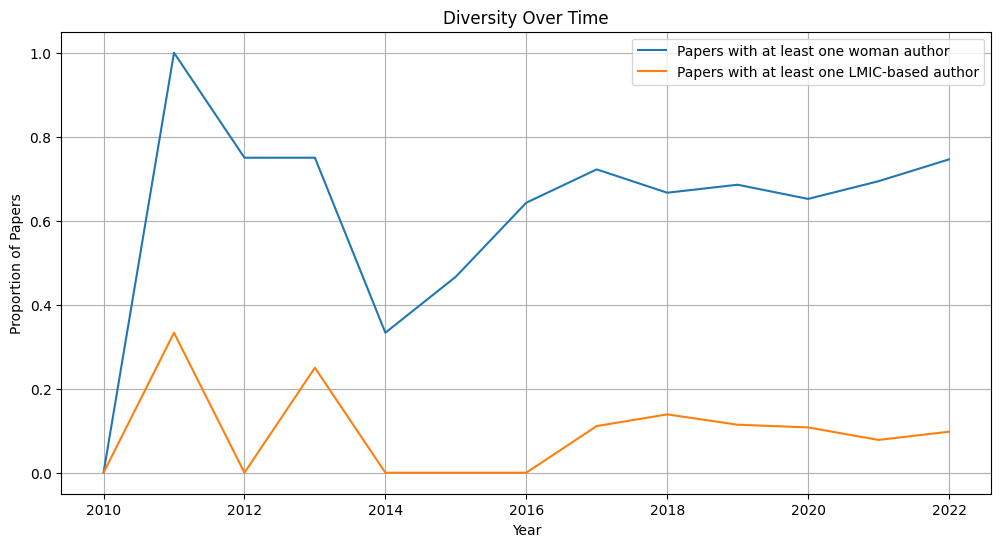

In [98]:

# Create a 'has_woman' column indicating if a paper has at least one female author
MIMIC_affli['has_woman'] = (MIMIC_affli['gender'] == 'female').astype(int)

# Create a 'has_LMIC' column indicating if a paper has at least one LMIC author
MIMIC_affli['has_LMIC'] = (MIMIC_affli['LMIC'] == 'Yes').astype(int)  # Assuming 'Yes' and 'No' values for LMIC

# Group by year and paper_id
grouped_df = MIMIC_affli.groupby(['year', 'pub_id'])

# Calculate the metric for each paper: 
# If at least one author is a woman or from LMIC for a given paper
papers_diversity = grouped_df[['has_woman', 'has_LMIC']].max()
papers_diversity = papers_diversity.reset_index()

# Calculate the yearly average for each metric
yearly_woman_metric = papers_diversity.groupby('year')['has_woman'].mean()
yearly_LMIC_metric = papers_diversity.groupby('year')['has_LMIC'].mean()

# Plotting
plt.figure(figsize=(12,6))
yearly_woman_metric.plot(label='Papers with at least one woman author')
yearly_LMIC_metric.plot(label='Papers with at least one LMIC-based author')
plt.title('Diversity Over Time')
plt.xlabel('Year')
plt.ylabel('Proportion of Papers')
plt.legend()
plt.grid(True)
plt.show()


In [101]:
# Filter for the year 2011
df_2011 = MIMIC_affli[MIMIC_affli['year'] == 2011]

# Group by paper_id and check for female authors
grouped_2011 = df_2011.groupby('pub_id')['gender'].apply(lambda x: (x == 'female').any())

# Check the proportion of papers in 2011 with at least one female author
proportion_female_authors_2011 = grouped_2011.mean()

print(f"Proportion of papers in 2011 with at least one female author: {proportion_female_authors_2011:.2f}")
print("\nNumber of papers in 2011:", grouped_2011.size)
print("Number of papers with at least one female author:", grouped_2011.sum())


Proportion of papers in 2011 with at least one female author: 1.00

Number of papers in 2011: 3
Number of papers with at least one female author: 3


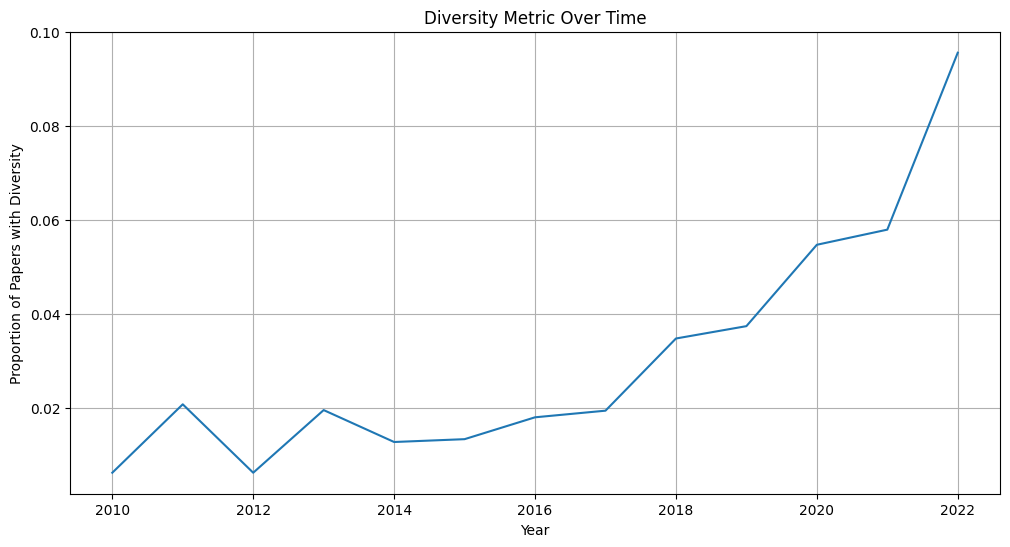

In [97]:

# Create a 'has_woman' column indicating if a paper has at least one female author
Control_affli['has_woman'] = (Control_affli['gender'] == 'female').astype(int)

# Create a 'has_LMIC' column indicating if a paper has at least one LMIC author
Control_affli['has_LMIC'] = (Control_affli['LMIC'] == 'Yes').astype(int)  # Assuming 'Yes' and 'No' values for LMIC

# Group by year and paper_id, then calculate the diversity metric
grouped_df = Control_affli.groupby(['year', 'pub_id'])
diversity_metric = grouped_df[['has_woman', 'has_LMIC']].max()  # max function will ensure if at least one is present
diversity_metric = diversity_metric.reset_index()

# Now group by year and calculate the average metric
yearly_metric = diversity_metric.groupby('year').apply(lambda x: (x['has_woman'] & x['has_LMIC']).mean())

# Plotting
plt.figure(figsize=(12,6))
yearly_metric.plot()
plt.title('Control Diversity Metric Over Time')
plt.xlabel('Year')
plt.ylabel('Proportion of Papers with Diversity')
plt.grid(True)
plt.show()
